# Data Analysis

Experimental data analysis accompanying the paper 'Rational Inattention and Psychometrics'.

Authors: Andrew Caplin, Daniel Csaba, John Leahy and Oded Nov

Date: October 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from patsy import dmatrix
from scipy import stats

%matplotlib inline

# set seaborn style
sns.set()
sns.set_style('whitegrid')
colors = sns.color_palette()

# set font
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

idx = pd.IndexSlice

In [2]:
# read in cleaned data set -- stripped from any identifier violating anonimity
df = pd.read_pickle('cleaned_data.pkl')

In [3]:
df.columns

Index(['BonusResult', 'Clock Stop Digits', 'Correct', 'Decoys/0', 'Decoys/1',
       'Incentives', 'N', 'Number of Shape/0', 'Number of Shape/1',
       'Number of Shape/2', 'Number of Shape/3', 'Response', 'Round',
       'Round Mudding/0', 'Round Mudding/1', 'Round Mudding/2',
       'Round Mudding/3', 'Score', 'TotalRound', 'age', 'date/time', 'm',
       'max', 'mudding', 'n', 'non-decoys/0', 'non-decoys/1', 'sex',
       'time_round', 'usercode', 'total time (min)'],
      dtype='object')

# Time patterns and types

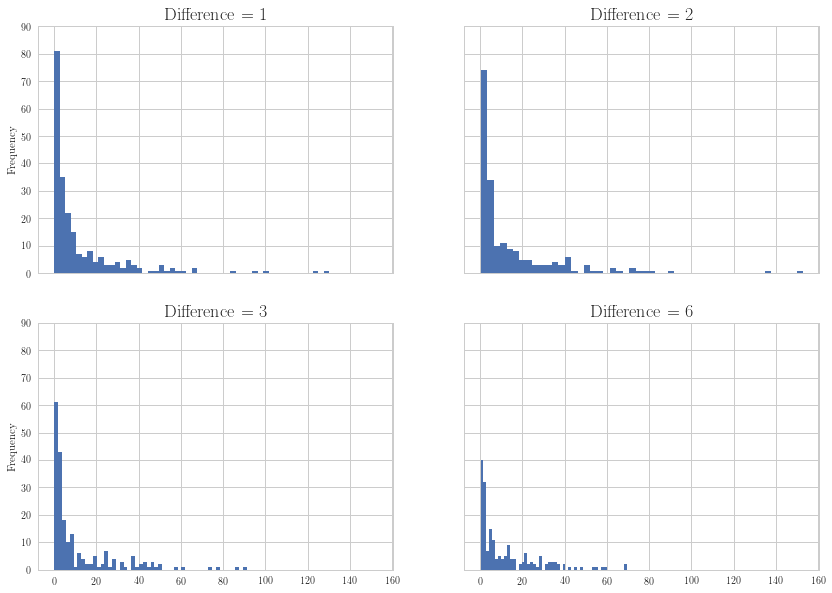

In [22]:
# plot distribution of total time spent on the experiment
# in the separate difficulty treatments

fig, axes = plt.subplots(2,2, figsize=(14, 10), sharex=True, sharey=True)

for diff, ax in zip(df['max'].unique(), fig.axes):
    df[df['max']==diff]['total time (min)'].groupby(df['usercode']).mean().plot(kind='hist', bins=50, ax=ax)
    ax.set_title('Difference = {}'.format(diff), fontsize=18)
    ax.set_ylim([0, 90])
    
plt.show()

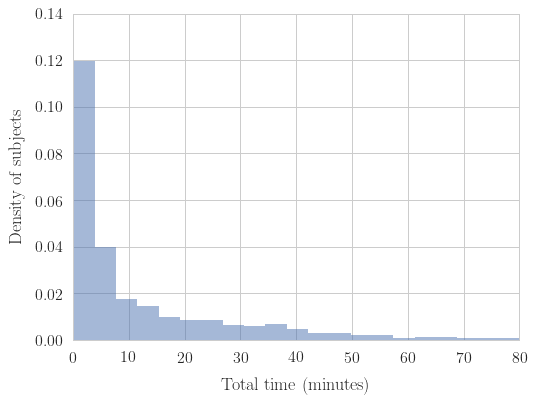

In [4]:
# pooled differences in total time
fig, ax = plt.subplots(figsize=(8,6))

df['total time (min)'].groupby(df['usercode']).mean().plot(kind='hist', bins=40, density=True, ax=ax, alpha=.5)
ax.set_xlabel('Total time (minutes)', fontsize=18, labelpad=10)
ax.set_ylabel('Density of subjects', fontsize=18, labelpad=10)
ax.set_xlim([0, 80])
ax.set_ylim([0, .14])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/total_time.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [5]:
# number of subjects above 80 minutes
df[df['total time (min)']>80]['usercode'].nunique()

10

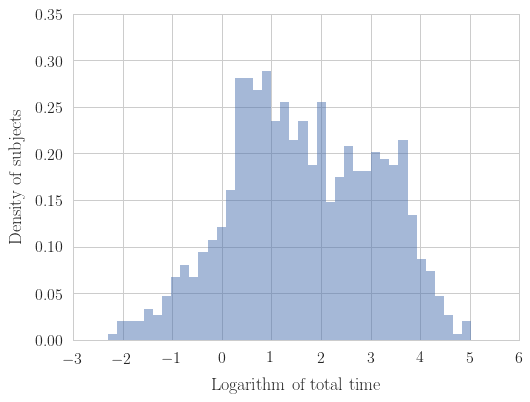

In [6]:
# plot log time distribution

df['log total time'] = np.log(df['total time (min)'])

# ==============

fig, ax = plt.subplots(figsize=(8,6))

df['log total time'].groupby(df['usercode']).mean().plot(kind='hist', bins=40, ax=ax, density=True, alpha=.5)
ax.set_xlabel('Logarithm of total time', fontsize=18, labelpad=10)
ax.set_ylabel('Density of subjects', fontsize=18, labelpad=10)
ax.set_xlim([-3, 6])
ax.set_ylim([0, .35])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/log_total_time.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

## Check whether inattentive strategy yields close to no chance of winning

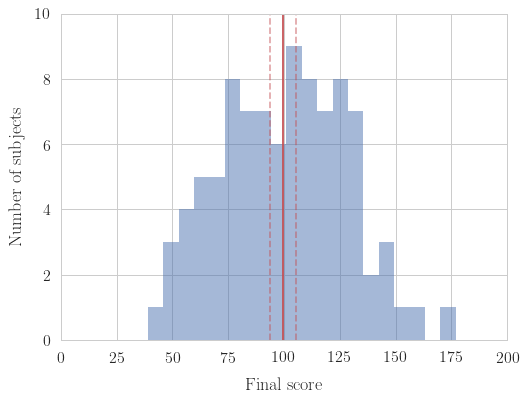

In [7]:
# get descriptive stat of the final score (in 40th round) given total time is less than 1 min
df_aux = df[(df['total time (min)']<1)&(df['Round']==40)]['Score'].describe()


fig, ax = plt.subplots(figsize=(8,6))

df[(df['total time (min)']<1)&(df['Round']==40)]['Score'].plot(kind='hist', bins=20,  ax=ax, alpha=.5)
ax.vlines(df_aux['mean'], 0, 10, color=colors[2])
ax.vlines([df_aux['mean']-1.96*df_aux['std']/np.sqrt(df_aux['count']), 
           df_aux['mean']+1.96*df_aux['std']/np.sqrt(df_aux['count'])], 0, 10, color=colors[2], linestyle='--', alpha=.5)
ax.set_xlabel('Final score', fontsize=18, labelpad=10)
ax.set_ylabel('Number of subjects', fontsize=18, labelpad=10)
ax.set_xlim([0, 200])
ax.set_ylim([0, 10])
ax.tick_params(labelsize=16, pad=10)


#plt.savefig('../Figures/Data/inattent_score.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [8]:
# Number of subjects spending less than 1 minute on the experiment
df[(df['total time (min)']<1)]['usercode'].nunique()

95

In [9]:
# Increasing the threshold increases the expected value
for t in [1, 2, 3, 4]:
    m = df[(df['total time (min)']<t)&(df['Round']==40)]['Score'].describe()['mean']
    print('Less than {} minutes, expected score: {:.2f}'.format(t, m))

Less than 1 minutes, expected score: 99.61
Less than 2 minutes, expected score: 106.41
Less than 3 minutes, expected score: 110.06
Less than 4 minutes, expected score: 111.30


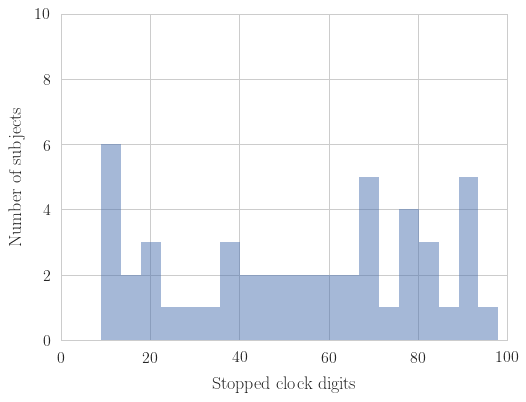

In [10]:
# distribution of stopped clock digits --should be roughly uniform
fig, ax = plt.subplots(figsize=(8,6))

df[(df['total time (min)']<1)&(df['Round']==40)]['Clock Stop Digits'].plot(kind='hist', bins=20,  ax=ax, alpha=.5)

ax.set_xlabel('Stopped clock digits', fontsize=18, labelpad=10)
ax.set_ylabel('Number of subjects', fontsize=18, labelpad=10)
ax.set_xlim([0, 100])
ax.set_ylim([0, 10])
ax.tick_params(labelsize=16, pad=10)

plt.show()

In [11]:
# compute the expected number of winners based on the achieved scores
exp_winners = np.sum((df[(df['total time (min)']<180)&(df['Round']==40)&(df['Score']>100)]['Score'].values - 100)/100)
print('The expected number of people winning conditional on being above 100 points: {}'.format(exp_winners))

The expected number of people winning conditional on being above 100 points: 320.86


In [12]:
# standard deviation of the expected number of winners
bernoulli_probs = (df[(df['total time (min)']<180)&(df['Round']==40)&(df['Score']>100)]['Score'].values - 100)/100
print('Standard deviation: {}.'.format(np.sqrt(np.sum(bernoulli_probs * (1-bernoulli_probs)))))

Standard deviation: 9.325674238359392.


In [13]:
print('Actual number of winners:')
df[(df['total time (min)']<180)&(df['Round']==40)][['BonusResult']].groupby(df['BonusResult']).count()

Actual number of winners:


,BonusResult
BonusResult,
Didn't win,315
Win,313


## Separating Inattentive Sample


The threshold that makes the probability of winning statistically different from zero.

In [14]:
# get descriptive stats below given threshold
M = np.empty(0)
CB = np.empty(0)

for t in np.linspace(0.1, 10, 50):
    m = df[(df['total time (min)']<t)&(df['Round']==40)]['Score'].describe()['mean']
    sd = df[(df['total time (min)']<t)&(df['Round']==40)]['Score'].describe()['std']
    n = df[(df['total time (min)']<t)&(df['Round']==40)]['Score'].describe()['count']
    M = np.append(M, m)
    CB = np.append(CB, sd/np.sqrt(n))
    

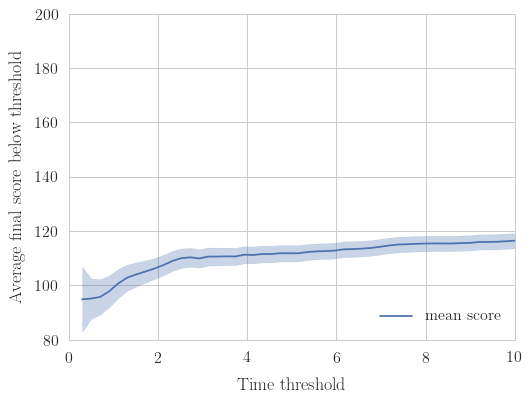

In [15]:
# plot mean and confidence band for pooled results below threshold

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.linspace(0.1, 10, 50), M, label = 'mean score')
ax.fill_between(np.linspace(.1, 10, 50), M-1.96*CB, M+1.96*CB, color=colors[0], alpha=.3)

ax.set_xlabel('Time threshold', fontsize=18, labelpad=10)
ax.set_ylabel('Average final score below threshold', fontsize=18, labelpad=10)
ax.set_xlim([0, 10])
ax.set_ylim([80, 200])
ax.tick_params(labelsize=16, pad=10)

plt.legend(loc=4, fontsize=16)
#plt.savefig('../Figures/Data/inattent_cum_scoremean.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

Do the same but now use a timewindow instead of pooling everyone below a certain time spent on the experiment.

In [16]:
M = np.empty(0)
CB = np.empty(0)

for t in np.linspace(0, 15, 50):
    w = 3 # window in minutes
    criteria = (df['total time (min)']>t-w/2)&(df['total time (min)']<t+w/2)&(df['Round']==40)&(df['max']==6)
    m = df[criteria]['Score'].describe()['mean']
    sd = df[criteria]['Score'].describe()['std']
    n = df[criteria]['Score'].describe()['count']
    M = np.append(M, m)
    CB = np.append(CB, sd/np.sqrt(n))
    


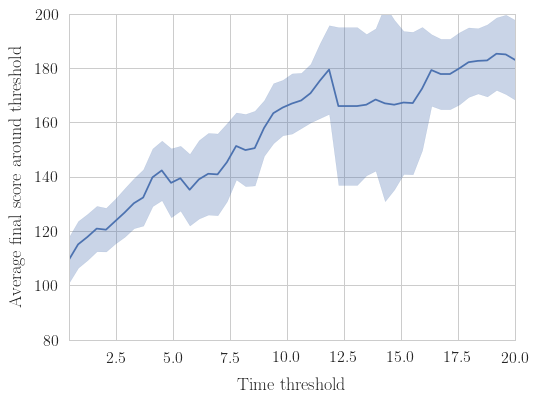

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.linspace(0, 20, 50), M) #label = 'mean score'
ax.fill_between(np.linspace(0, 20, 50), M-1.96*CB, M+1.96*CB, color=colors[0], alpha=.3)

ax.set_xlabel('Time threshold', fontsize=18, labelpad=10)
ax.set_ylabel('Average final score around threshold', fontsize=18, labelpad=10)
ax.set_xlim([0.4, 20])
ax.set_ylim([80, 200])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/average_timewindow.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

## Setting the threshold

In [4]:
th = 5 # threshold in minutes

attentive = (df['total time (min)']>=th)
inattentive = (df['total time (min)']<th)

In [5]:
# number of subjects in the attentive subsample
df[attentive].usercode.nunique()

402

In [6]:
# number of subjects across difficulty levels in the attentive subsample
df[attentive].usercode.groupby(df['max']).nunique()

max
1    112
2     97
3     90
6    103
Name: usercode, dtype: int64

In [7]:
# reminder of total sample size
df.usercode.groupby(df['max']).nunique()

max
1    223
2    195
3    208
6    188
Name: usercode, dtype: int64

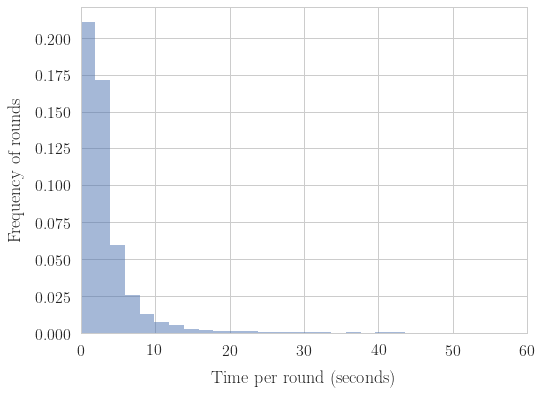

In [22]:
# distribution of time per round within inattentive sample
fig, ax = plt.subplots(figsize=(8,6))

df[inattentive]['time_round'].plot(kind='hist', bins=100, density=True, ax=ax, alpha=.5)
ax.set_xlabel('Time per round (seconds)', fontsize=18, labelpad=10)
ax.set_ylabel('Frequency of rounds', fontsize=18, labelpad=10)
ax.set_xlim([0, 60])
#ax.set_ylim([0, 250])
ax.tick_params(labelsize=16, pad=10)

plt.show()

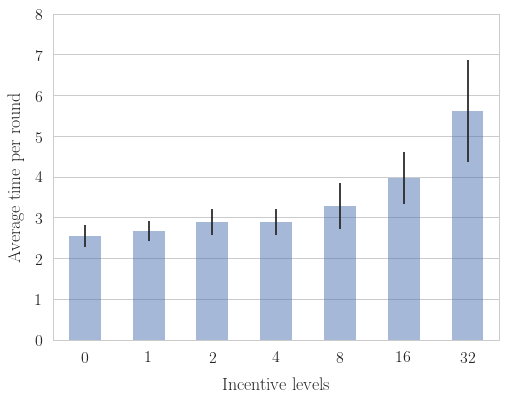

In [23]:
inattentive = (df['total time (min)']<5)


# confidence intervals
df_inatt_time = df[inattentive]['time_round'].groupby([df['Incentives']]).describe() 

# std/sqrt(n)
std_per_sqrt_n = df_inatt_time['std'].values/np.sqrt(df_inatt_time['count'].values)
crit_val = stats.t.ppf(1-0.025, df=df_inatt_time['count'].values)
yerr = 2*crit_val*std_per_sqrt_n

#===============

fig, ax = plt.subplots(figsize=(8,6))

df[inattentive]['time_round'].groupby([df['Incentives']]).mean().plot(kind='bar', color=colors[0], rot=0, alpha=.5,
                                                                      yerr=yerr, ax=ax)

ax.set_xlabel('Incentive levels', fontsize=18, labelpad=10)
ax.set_ylabel('Average time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_ylim([0, 8])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/inattentive_meantime.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

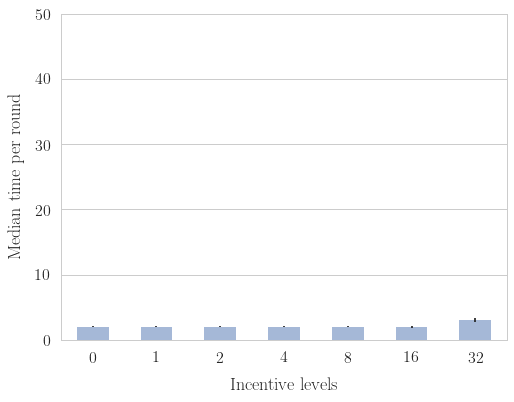

In [24]:
fig, ax = plt.subplots(figsize=(8,6))

# add confidence band for median
yerr = (1.57*(df_inatt_time['75%'].values - df_inatt_time['25%'].values))/(np.sqrt(df_inatt_time['count'].values))

df[inattentive]['time_round'].groupby([df['Incentives']]).median().plot(kind='bar', color=colors[0], rot=0, alpha=.5,
                                                                        yerr=yerr, ax=ax)

ax.set_xlabel('Incentive levels', fontsize=18, labelpad=10)
ax.set_ylabel('Median time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_ylim([0, 50])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/inattentive_mediantime.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

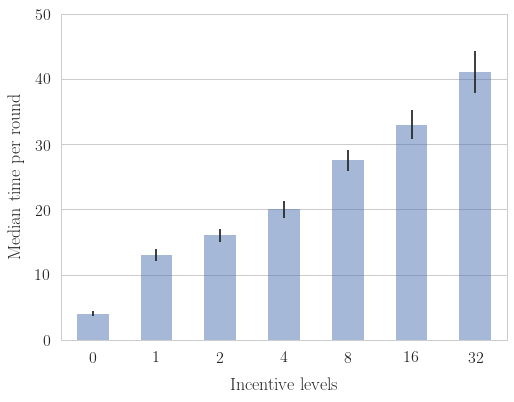

In [25]:
# confidence intervals
df_att_time = df[attentive]['time_round'].groupby([df['Incentives']]).describe() 


fig, ax = plt.subplots(figsize=(8,6))

# add confidence band for median
yerr = (1.57*(df_att_time['75%'].values - df_att_time['25%'].values))/(np.sqrt(df_att_time['count'].values))

df[attentive]['time_round'].groupby([df['Incentives']]).median().plot(kind='bar', color=colors[0], rot=0, alpha=.5,
                                                                        yerr=yerr, ax=ax)

ax.set_xlabel('Incentive levels', fontsize=18, labelpad=10)
ax.set_ylabel('Median time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_ylim([0, 50])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/attentive_mediantime.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

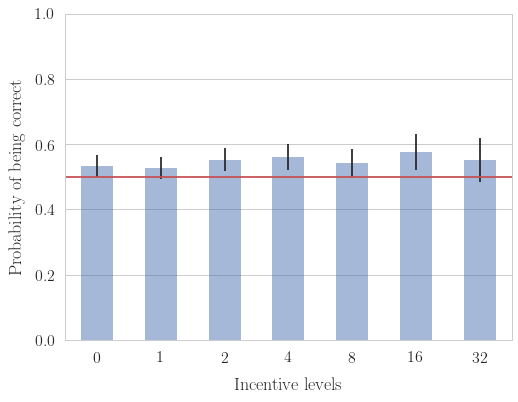

In [26]:
# confidence intervals
df_inatt_correct = df[inattentive]['Correct'].groupby([df['Incentives']]).describe()

# std/sqrt(n)
std_per_sqrt_n = df_inatt_correct['std'].values/np.sqrt(df_inatt_correct['count'].values)
crit_val = stats.t.ppf(1-0.025, df=df_inatt_correct['count'].values)
yerr = 2*crit_val*std_per_sqrt_n

#===============

fig, ax = plt.subplots(figsize=(8,6))


df[inattentive]['Correct'].groupby([df['Incentives']]).mean().plot(kind='bar', color=colors[0], rot=0, alpha=.5,
                                                                      yerr=yerr, ax=ax)
ax.axhline(.5, -1, 10, color=colors[2])
ax.set_xlabel('Incentive levels', fontsize=18, labelpad=10)
ax.set_ylabel('Probability of being correct', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_ylim([0, 1])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/inattentive_meancorrect.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

# Achieved scores in the attentive subsample 

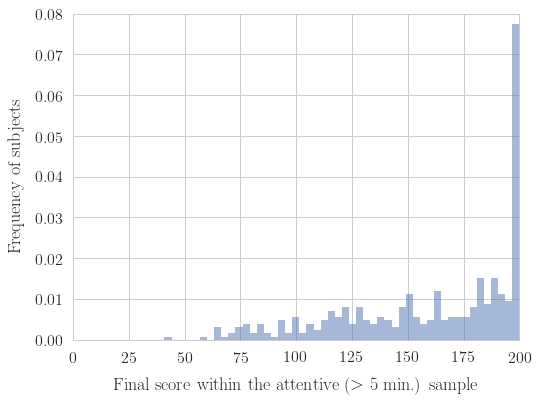

In [5]:
# distribution of final scores within attentive subsample
fig, ax = plt.subplots(figsize=(8,6))

df[attentive & (df['Round']==40)]['Score'].plot(kind='hist', bins=50, density=True, ax=ax, alpha=.5)
ax.set_xlabel('Final score within the attentive ($>$ 5 min.) sample', fontsize=18, labelpad=10)
ax.set_ylabel('Frequency of subjects', fontsize=18, labelpad=10)
ax.set_xlim([0, 200])
ax.set_ylim([0, .08])
ax.tick_params(labelsize=16, pad=10)

plt.show()

In [6]:
df[attentive & (df['Round']==40)]['Score'].describe()

count    394.000000
mean     159.835025
std       39.348132
min       41.000000
25%      130.000000
50%      171.000000
75%      196.000000
max      200.000000
Name: Score, dtype: float64

In [28]:
df[attentive & (df['Round']==40) & (df['Score']<100)]['usercode'].count()

37

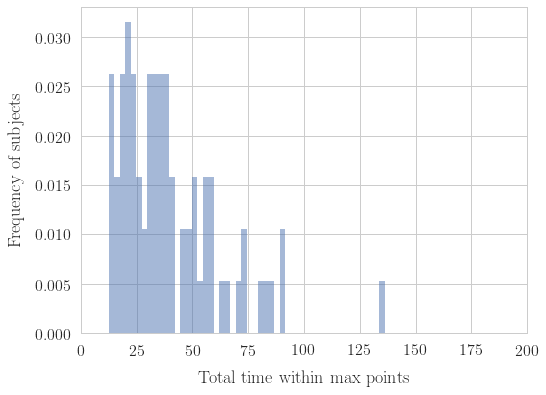

In [29]:
# total time spent on experiment for subsample achieving full score
fig, ax = plt.subplots(figsize=(8,6))

df[(df['Round']==40) & (df['Score']==200)]['total time (min)'].plot(kind='hist', bins=50, density=True,  ax=ax, alpha=.5)
ax.set_xlabel('Total time within max points', fontsize=18, labelpad=10)
ax.set_ylabel('Frequency of subjects', fontsize=18, labelpad=10)
ax.set_xlim([0, 200])
#ax.set_ylim([0, 250])
ax.tick_params(labelsize=16, pad=10)

plt.show()


In [30]:
# save perfect scorers
perf_scorers = df[(df['Score']==200)]['usercode'].unique()

# Number of subjects who scored perfect
df[(df['Score']==200)]['usercode'].nunique()

77

## Normalizing time for each subject

Relative to median/mean?

Median problematic for inattentives -- often zero -- only measured integer seconds

In [8]:
# median time for each user across all incentive levels
df_mediantime_user = df[['time_round']].groupby([df['usercode']]).median()
df_mediantime_user.rename(columns={'time_round':'median user_time'}, inplace=True)

df = df.join(df_mediantime_user, on=['usercode'])

df['norm_time_to_median'] = df['time_round']/df['median user_time']

In [9]:
# mean time for each user across all incentive levels
df_meantime_user = df[['time_round']].groupby([df['usercode']]).mean()
df_meantime_user.rename(columns={'time_round':'mean user_time'}, inplace=True)

df = df.join(df_meantime_user, on=['usercode'])

df['norm_time_to_mean'] = df['time_round']/df['mean user_time']

In [33]:
df['norm_time_to_mean'].describe()

count    32560.000000
mean         1.000000
std          1.480239
min          0.000000
25%          0.318725
50%          0.721178
75%          1.206030
max         39.355164
Name: norm_time_to_mean, dtype: float64

In [34]:
df['median user_time'].describe()

count    32560.000000
mean        13.144349
std         22.938531
min          0.000000
25%          2.000000
50%          3.500000
75%         12.500000
max        233.000000
Name: median user_time, dtype: float64

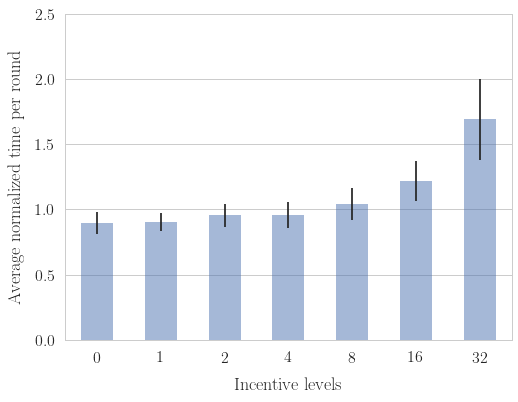

In [35]:
# confidence intervals
df_inatt_norm = df[inattentive]['norm_time_to_mean'].groupby([df['Incentives']]).describe()


# std/sqrt(n)
std_per_sqrt_n = df_inatt_norm['std'].values/np.sqrt(df_inatt_norm['count'].values)
crit_val = stats.t.ppf(1-0.025, df=df_inatt_norm['count'].values)
yerr = 2*crit_val*std_per_sqrt_n

# =======================

fig, ax = plt.subplots(figsize=(8,6))

df[inattentive]['norm_time_to_mean'].groupby([df['Incentives']]).mean().plot(kind='bar', color=colors[0], rot=0,
                                                                             yerr=yerr, alpha=.5, ax=ax)

ax.set_xlabel('Incentive levels', fontsize=18, labelpad=10)
ax.set_ylabel('Average normalized time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_ylim([0, 2.5])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/inattentive_normtime.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

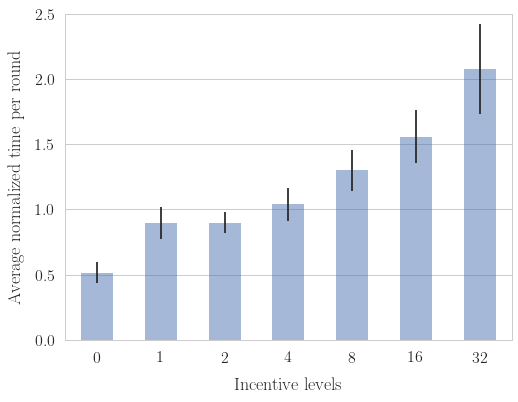

In [36]:
# confidence intervals

df_att_norm = df[attentive]['norm_time_to_mean'].groupby([df['Incentives']]).describe()


# std/sqrt(n)
std_per_sqrt_n = df_att_norm['std'].values/np.sqrt(df_att_norm['count'].values)
crit_val = stats.t.ppf(1-0.025, df=df_att_norm['count'].values)
yerr = 2*crit_val*std_per_sqrt_n

# =======================

fig, ax = plt.subplots(figsize=(8,6))

df[attentive]['norm_time_to_mean'].groupby([df['Incentives']]).mean().plot(kind='bar', color=colors[0], rot=0,
                                                                             yerr=yerr, alpha=.5, ax=ax)

ax.set_xlabel('Incentive levels', fontsize=18, labelpad=10)
ax.set_ylabel('Average normalized time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_ylim([0, 2.5])
ax.tick_params(labelsize=16, pad=10)

#plt.savefig('../Figures/Data/attentive_normtime.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

# Checking for NIAS and NIAC

In [10]:
df[['Number of Shape/0', 'Number of Shape/2']].head()

,Number of Shape/0,Number of Shape/2
0,heptagon:8,nonagon:9
1,heptagon:8,nonagon:9
2,heptagon:4,nonagon:3
3,heptagon:5,nonagon:6
4,heptagon:6,nonagon:7


In [11]:
# define state based on heptagon or nonagon shapes are more numerous
df['state'] = np.where(df['Number of Shape/0'].str.split(':', expand=True)[1]>df['Number of Shape/2'].str.split(':', expand=True)[1],
                       'heptagon', 'nonagon')

In [12]:
# Empirical frequency of the states

df['state'].value_counts(normalize=True)

nonagon     0.501658
heptagon    0.498342
Name: state, dtype: float64

In [13]:
df['state'].groupby([df['max']]).value_counts(normalize=True)

max  state   
1    nonagon     0.504148
     heptagon    0.495852
2    nonagon     0.504103
     heptagon    0.495897
3    nonagon     0.501202
     heptagon    0.498798
6    heptagon    0.503324
     nonagon     0.496676
Name: state, dtype: float64

In [14]:
df_NIAS = df['Correct'].groupby([df['max'], df['Incentives'], df['state']]).value_counts(normalize=True).to_frame(name='Average')

df_NIAS_count = df['Correct'].groupby([df['max'], df['Incentives'], df['state']]).count().to_frame(name='Count')

df_NIAS = df_NIAS.unstack()

df_NIAS.columns = [tup[0] + '_' + str(tup[1]) for tup in df_NIAS.columns.values]

df_NIAS = df_NIAS.join(df_NIAS_count, how='inner')

df_NIAS = df_NIAS.unstack()

df_NIAS.head()

Average_0           Average_1              Count        
state           heptagon   nonagon  heptagon   nonagon heptagon nonagon
max Incentives                                                         
1   0           0.437714  0.487349  0.562286  0.512651      875     909
    1           0.420417  0.422680  0.579583  0.577320      911     873
    2           0.386127  0.392818  0.613873  0.607182      865     919
    4           0.394895  0.382440  0.605105  0.617560      666     672
    8           0.376114  0.371841  0.623886  0.628159      561     554

Test NIAS conditions based on the inequality 
$$P_\pi(a_\pi(7)\mid \omega_7) - P_\pi(a_\pi(7)\mid \omega_9)\geq 0$$

That is $p(7|7) - p(7|9)\geq0$.


t-test is
$$ \frac{\widehat{p(7|7)} - \widehat{p(7|9)}}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_7} + \frac{1}{n_9})}}$$

with $\hat{p} = \frac{n_7 \widehat{p(7|7)} + n_9 \widehat{p(7|9)}}{n_7 + n_9}$.

In [15]:
import scipy.stats as st

def NIAS_test(row):
    p_77 = row.loc[idx['Average_1', 'heptagon']]
    p_79 = row.loc[idx['Average_0', 'nonagon']]
    n_7 = row.loc[idx['Count', 'heptagon']]
    n_9 = row.loc[idx['Count', 'nonagon']]
    # proportion under null
    p = (n_7*p_77 + n_9*p_79)/(n_7 + n_9)
    # s.e. under null
    se = np.sqrt(p*(1-p)*(1/n_7 + 1/n_9))
    # t-stat
    t_stat = (p_77 - p_79)/se 
    return 1 - st.t.cdf(t_stat, n_7 + n_9 - 2)

In [16]:
df_NIAS_pvalue = df_NIAS.apply(lambda row: NIAS_test(row), axis=1).to_frame(name='P-values')

In [17]:
df_NIAS_pvalue.unstack()

P-values                                                      \
Incentives            0             1    2             4    8             16   
max                                                                            
1           7.797918e-04  2.281131e-11  0.0  4.440892e-16  0.0  2.785505e-11   
2           7.271217e-07  3.441691e-15  0.0  0.000000e+00  0.0  1.110223e-16   
3           1.228450e-09  0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00   
6           0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00   

                          
Incentives            32  
max                       
1           6.179333e-05  
2           1.978211e-10  
3           1.522116e-13  
6           0.000000e+00

In [18]:
(df_NIAS_pvalue<.01).sum()

P-values    28
dtype: int64

## check for attentive subsample


In [19]:
df_NIAS_att = df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives'], df['state']]).value_counts(normalize=True).to_frame(name='Average')

df_NIAS_count_att = df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives'], df['state']]).count().to_frame(name='Count')

df_NIAS_att = df_NIAS_att.unstack()

df_NIAS_att.columns = [tup[0] + '_' + str(tup[1]) for tup in df_NIAS_att.columns.values]

df_NIAS_att = df_NIAS_att.join(df_NIAS_count_att, how='inner')

df_NIAS_att = df_NIAS_att.unstack()

df_NIAS_att.head()

Average_0           Average_1              Count        
state           heptagon   nonagon  heptagon   nonagon heptagon nonagon
max Incentives                                                         
1   0           0.428899  0.491304  0.571101  0.508696      436     460
    1           0.365256  0.340045  0.634744  0.659955      449     447
    2           0.297424  0.307036  0.702576  0.692964      427     469
    4           0.298817  0.332335  0.701183  0.667665      338     334
    8           0.275472  0.332203  0.724528  0.667797      265     295

In [20]:
df_NIAS_att_pvalue = df_NIAS_att.apply(lambda row: NIAS_test(row), axis=1).to_frame(name='P-values')

In [21]:
df_NIAS_att_pvalue.unstack()

P-values                                                
Incentives        0    1    2    4    8             16            32
max                                                                 
1           0.008480  0.0  0.0  0.0  0.0  1.942890e-14  4.185495e-10
2           0.000003  0.0  0.0  0.0  0.0  0.000000e+00  2.198242e-13
3           0.000000  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00
6           0.000000  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00

In [22]:
#print(df_NIAS_att_pvalue.unstack(level=0).round(3).to_latex(float_format='%.3f'))

In [23]:
(df_NIAS_att_pvalue<.01).sum()

P-values    28
dtype: int64

## check for inattentive subsample


In [24]:
df_NIAS_inatt = df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives'], df['state']]).value_counts(normalize=True).to_frame(name='Average')

df_NIAS_count_inatt = df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives'], df['state']]).count().to_frame(name='Count')

df_NIAS_inatt = df_NIAS_inatt.unstack()

df_NIAS_inatt.columns = [tup[0] + '_' + str(tup[1]) for tup in df_NIAS_inatt.columns.values]

df_NIAS_inatt = df_NIAS_inatt.join(df_NIAS_count_inatt, how='inner')

df_NIAS_inatt = df_NIAS_inatt.unstack()

df_NIAS_inatt.head()

Average_0           Average_1              Count        
state           heptagon   nonagon  heptagon   nonagon heptagon nonagon
max Incentives                                                         
1   0           0.446469  0.483296  0.553531  0.516704      439     449
    1           0.474026  0.509390  0.525974  0.490610      462     426
    2           0.472603  0.482222  0.527397  0.517778      438     450
    4           0.493902  0.431953  0.506098  0.568047      328     338
    8           0.466216  0.416988  0.533784  0.583012      296     259

In [25]:
df_NIAS_inatt_pvalue = df_NIAS_inatt.apply(lambda row: NIAS_test(row), axis=1).to_frame(name='P-values')

In [26]:
(df_NIAS_inatt_pvalue<.05).sum()

P-values    20
dtype: int64

In [27]:
#print(df_NIAS_inatt_pvalue.unstack(level=0).round(3).to_latex())

## NIAC

We need the average probabilities of being correct to be increasing for each difficulty level.

In [28]:
df_NIAC = df['Correct'].groupby([df['max'], df['Incentives']]).mean().to_frame(name='Average correct')

df_NIAC['Count'] = df['Correct'].groupby([df['max'], df['Incentives']]).count()

df_NIAC['Average correct shift'] = df_NIAC['Average correct'].shift(1)
df_NIAC['Count shift'] = df_NIAC['Count'].shift(1)

In [29]:
def NIAC_test(row):
    p_high = row['Average correct']
    p_low = row['Average correct shift']
    n_high = row['Count']
    n_low = row['Count shift']
    # proportion under null
    p = (n_high*p_high + n_low*p_low)/(n_high + n_low)
    # s.e. under null
    se = np.sqrt(p*(1-p)*(1/n_high + 1/n_low))
    # t-stat
    t_stat = (p_high - p_low)/se 
    return 1 - st.t.cdf(t_stat, n_high + n_low - 2)
    

In [30]:
# P values of NIAC tests
df_NIAC.apply(lambda row: NIAC_test(row), axis=1).unstack(level=0).loc[1:32].round(3)

max,1,2,3,6
Incentives,,,,
1,0.006,0.016,0.004,0.000
2,0.026,0.007,0.020,0.232
4,0.479,0.270,0.731,0.179
8,0.229,0.684,0.418,0.762
16,0.445,0.087,0.059,0.009
32,0.895,0.692,0.467,0.360


In [58]:
# probability of correct for NIAC tests
df['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0)

max,1,2,3,6
Incentives,,,,
0,0.536996,0.561538,0.572716,0.646277
1,0.578475,0.599359,0.617788,0.716755
2,0.610426,0.641667,0.652043,0.728723
4,0.611360,0.652991,0.641026,0.744681
8,0.626009,0.643077,0.645192,0.730851
16,0.629297,0.676923,0.682692,0.785461
32,0.591928,0.661538,0.685096,0.795213


In [134]:
#print(df['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).to_latex(float_format='%.3f'))

Restrict sample to attentive.

In [31]:
df_NIAC_att = df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives']]).mean().to_frame(name='Average correct')

df_NIAC_att['Count'] = df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives']]).count()

df_NIAC_att['Average correct shift'] = df_NIAC_att['Average correct'].shift(1)
df_NIAC_att['Count shift'] = df_NIAC_att['Count'].shift(1)

In [32]:
# p-values for NIAC tests -- attentive sample
df_NIAC_att.apply(lambda row: NIAC_test(row), axis=1).unstack(level=0).round(3).loc[1:32]

max,1,2,3,6
Incentives,,,,
1,0.000,0.000,0.011,0.000
2,0.012,0.026,0.035,0.447
4,0.710,0.493,0.365,0.393
8,0.351,0.202,0.323,0.110
16,0.237,0.345,0.055,0.051
32,0.530,0.553,0.318,0.450


In [33]:
# probability of correct for NIAC tests
df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).round(3)

max,1,2,3,6
Incentives,,,,
0,0.539,0.584,0.667,0.716
1,0.647,0.705,0.722,0.839
2,0.698,0.749,0.764,0.841
4,0.685,0.749,0.772,0.846
8,0.695,0.771,0.784,0.872
16,0.717,0.784,0.833,0.909
32,0.714,0.778,0.850,0.913


In [40]:
#print(df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).to_latex(float_format='%.3f'))

In [36]:
# get the difference
df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).diff()
#print(df[df['total time (min)']>=5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).diff().to_latex(float_format='%.3f'))

max,1,2,3,6
Incentives,,,,
0,NaN,NaN,NaN,NaN
1,0.108259,0.121134,0.055556,0.122573
2,0.050223,0.043814,0.041667,0.002427
4,-0.013021,0.000430,0.008333,0.005259
8,0.010119,0.021993,0.012222,0.025566
16,0.022619,0.012371,0.048889,0.037540
32,-0.002976,-0.005155,0.016667,0.003236


Restrict sample to inattentive.

In [37]:
df_NIAC_inatt = df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives']]).mean().to_frame(name='Average correct')

df_NIAC_inatt['Count'] = df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives']]).count()

df_NIAC_inatt['Average correct shift'] = df_NIAC_inatt['Average correct'].shift(1)
df_NIAC_inatt['Count shift'] = df_NIAC_inatt['Count'].shift(1)

In [38]:
# p-values for NIAC tests -- attentive sample
df_NIAC_inatt.apply(lambda row: NIAC_test(row), axis=1).unstack(level=0).round(3).loc[1:32]

max,1,2,3,6
Incentives,,,,
1,0.863,0.961,0.054,0.392
2,0.284,0.053,0.106,0.190
4,0.279,0.208,0.852,0.156
8,0.251,0.913,0.528,0.972
16,0.681,0.067,0.195,0.027
32,0.952,0.711,0.581,0.355


In [39]:
# probability of correct for NIAC tests -- inattentive
df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).round(3)

max,1,2,3,6
Incentives,,,,
0,0.535,0.540,0.501,0.562
1,0.509,0.495,0.538,0.569
2,0.523,0.536,0.567,0.593
4,0.538,0.558,0.541,0.622
8,0.557,0.516,0.539,0.560
16,0.541,0.571,0.568,0.635
32,0.468,0.546,0.559,0.653


In [66]:
#print(df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).to_latex(float_format='%.3f'))

In [43]:
# get the difference
df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).diff().round(3)
#print(df[df['total time (min)']<5]['Correct'].groupby([df['max'], df['Incentives']]).mean().unstack(level=0).diff().to_latex(float_format='%.3f'))

max,1,2,3,6
Incentives,,,,
0,NaN,NaN,NaN,NaN
1,-0.026,-0.045,0.037,0.007
2,0.014,0.041,0.029,0.024
4,0.015,0.022,-0.026,0.029
8,0.019,-0.041,-0.002,-0.062
16,-0.016,0.055,0.029,0.075
32,-0.072,-0.026,-0.008,0.018


## Fatigue and Learning

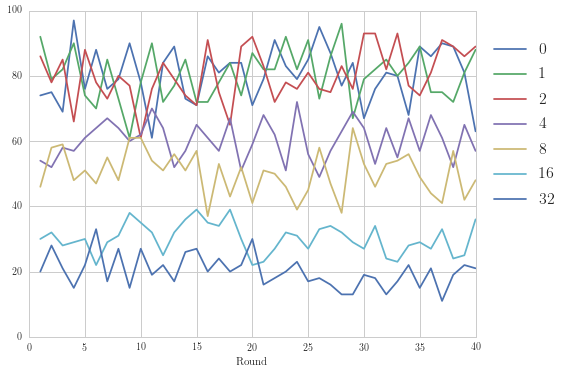

In [67]:
# Incentive levels have the same frequency across rounds so we pool them

fig, ax = plt.subplots(figsize=(8,6))

df[attentive]['Correct'].groupby([df['Incentives'], df['Round']]).count().unstack(level=0).plot(kind='line', ax=ax)
ax.set_ylim([0,100])
ax.set_xlim([0,40])
plt.legend(bbox_to_anchor=(1.01, .95), fontsize=16)
plt.show()

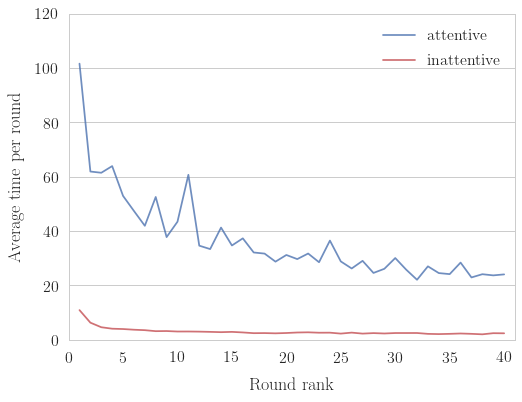

In [68]:
fig, ax = plt.subplots(figsize=(8,6))

df[attentive]['time_round'].groupby([df['Round']]).mean().plot(kind='line', color=colors[0], 
                                                               alpha=.8, ax=ax, label='attentive')
df[inattentive]['time_round'].groupby([df['Round']]).mean().plot(kind='line', color=colors[2],
                                                                 alpha=.8, ax=ax, label='inattentive')

ax.set_xlabel('Round rank', fontsize=18, labelpad=10)
ax.set_ylabel('Average time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_xlim([0, 41])
ax.set_ylim([0, 120])
ax.tick_params(labelsize=16, pad=10)

plt.legend(fontsize=16)
#plt.savefig('../Figures/Data/meantime_round.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

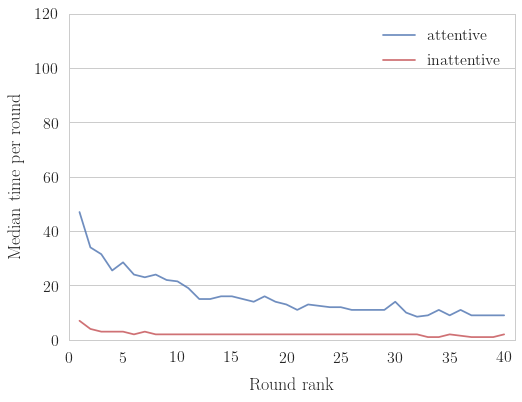

In [69]:
fig, ax = plt.subplots(figsize=(8,6))

df[attentive]['time_round'].groupby([df['Round']]).median().plot(kind='line', color=colors[0], 
                                                               alpha=.8, ax=ax, label='attentive')
df[inattentive]['time_round'].groupby([df['Round']]).median().plot(kind='line', color=colors[2],
                                                                 alpha=.8, ax=ax, label='inattentive')


ax.set_xlabel('Round rank', fontsize=18, labelpad=10)
ax.set_ylabel('Median time per round', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_xlim([0, 41])
ax.set_ylim([0, 120])
ax.tick_params(labelsize=16, pad=10)

plt.legend(fontsize=16)
#plt.savefig('../Figures/Data/mediantime_round.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [44]:
OLS_learning = {}
for i, criteria in enumerate([attentive, inattentive]):
    endog = df[criteria]['Correct']
    exog = sm.add_constant(df[criteria]['Round'])
    model = smf.ols(formula='Correct ~ Round', data=df[criteria])
    OLS_learning[i] = model.fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})

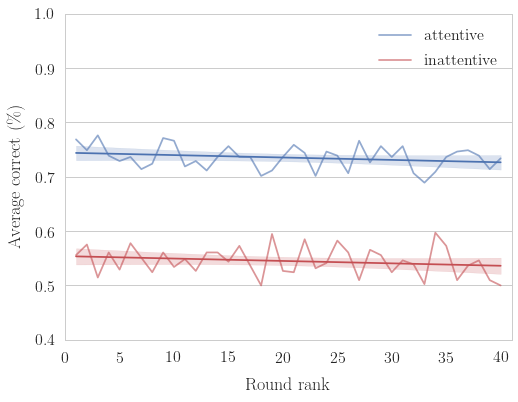

In [46]:
df_exog = pd.DataFrame(np.arange(1,41, 1), columns=['Round'])

fig, ax = plt.subplots(figsize=(8,6))

# ============
# attentive
# ============


# confidence band
n = df[attentive]['Round'].shape[0]
x_mean = df[attentive]['Round'].mean()
dof = n - OLS_learning[0].df_model - 1
t = stats.t.ppf(1-0.025, df=dof)
se = np.sqrt((OLS_learning[0].resid.values**2).sum()/(n-2))
conf = t * se * np.sqrt(1.0/n + ((np.arange(1,41, 1)-x_mean)**2 /
                                  ((df[attentive]['Round'].values-x_mean)**2).sum()))

upper = OLS_learning[0].predict(df_exog) + conf
lower = OLS_learning[0].predict(df_exog) - conf


df[attentive]['Correct'].groupby([df['Round']]).mean().plot(kind='line', color=colors[0], 
                                                               alpha=.6, ax=ax, label='attentive')

ax.plot(np.arange(1,41, 1), OLS_learning[0].predict(df_exog), color=colors[0], alpha=1)
ax.fill_between(np.arange(1,41, 1), lower, upper, color=colors[0], alpha=0.2)

# ============
# inattentive
# ============

# confidence band
n = df[inattentive]['Round'].shape[0]
x_mean = df[inattentive]['Round'].mean()
dof = n - OLS_learning[1].df_model - 1
t = stats.t.ppf(1-0.025, df=dof)
se = np.sqrt((OLS_learning[1].resid.values**2).sum()/(n-2))
conf = t * se * np.sqrt(1.0/n + ((np.arange(1,41, 1)-x_mean)**2 /
                                  ((df[inattentive]['Round'].values-x_mean)**2).sum()))

upper = OLS_learning[1].predict(df_exog) + conf
lower = OLS_learning[1].predict(df_exog) - conf


df[inattentive]['Correct'].groupby([df['Round']]).mean().plot(kind='line', color=colors[2],
                                                                 alpha=.6, ax=ax, label='inattentive')
ax.plot(np.arange(1,41, 1), OLS_learning[1].predict(df_exog), color=colors[2], alpha=1)
ax.fill_between(np.arange(1,41, 1), lower, upper, color=colors[2], alpha=0.2)


ax.set_xlabel('Round rank', fontsize=18, labelpad=10)
ax.set_ylabel('Average correct (\%)', fontsize=18, labelpad=10)
ax.xaxis.grid(False)
ax.set_xlim([0, 41])
ax.set_ylim([0.4, 1])
ax.tick_params(labelsize=16, pad=10)

plt.legend(fontsize=16)
plt.savefig('../Figures/Data/precision_round.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [47]:
#OLS_learning[0].summary()

In [48]:
#OLS_learning[1].summary()

In [47]:
reg_names = ['Attentive', 'Inattentive']
info_dict = {'Adj. R-squared': lambda x: '{:.2f}'.format(x.rsquared_adj),
             'No. observations': lambda x: '{:d}'.format(int(x.nobs))}


reg_table = summary_col([OLS_learning[0], OLS_learning[1]], 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)
                       
reg_table.add_title('Performance across rounds')

print(reg_table.as_latex())
#reg_table

\begin{table}
\caption{Performance across rounds}
\begin{center}
\begin{tabular}{lcc}
\hline
                 & Attentive & Inattentive  \\
\midrule
\midrule
Intercept        & 0.744***  & 0.554***     \\
                 & (0.010)   & (0.008)      \\
Round            & -0.000    & -0.000       \\
                 & (0.000)   & (0.000)      \\
Adj. R-squared   & 0.00      & 0.00         \\
No. observations & 16080     & 16480        \\
\hline
\end{tabular}
\end{center}
\end{table}


# Analysis of the Probability of Being Correct

In [48]:
# reset criteria
th = 5
criteria = (df['total time (min)']>=th) # attentive subsample

## Log transform of incentives

In [49]:
df[criteria].shape

(16080, 36)

In [50]:
model_pooled_log = smf.logit(formula='Correct ~ C(max)*np.log(Incentives+1)', 
                            data=df[criteria]).fit(cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})

Optimization terminated successfully.
         Current function value: 0.559133
         Iterations 6


In [51]:
model_pooled_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Correct   No. Observations:                16080
Model:                          Logit   Df Residuals:                    16072
Method:                           MLE   Df Model:                            7
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:                 0.03278
Time:                        00:53:16   Log-Likelihood:                -8990.9
converged:                       True   LL-Null:                       -9295.6
                                        LLR p-value:                2.281e-127
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.3570      0.068      5.253      0.000       0.224       0.490
C(max)[T.2]                            0.1892      0.106      1.781      0.075      -0.019       0.397
C(max)[T.3]                            0.3869      0.118      3.272      0.001       0.155       0.619
C(max)[T.6]                            0.7397      0.126      5.888      0.000       0.493       0.986
np.log(Incentives + 1)                 0.2347      0.045      5.185      0.000       0.146       0.323
C(max)[T.2]:np.log(Incentives + 1)     0.0726      0.069      1.048      0.295      -0.063       0.208
C(max)[T.3]:np.log(Incentives + 1)     0.0605      0.068      0.885      0.376      -0.073       0.194
C(max)[T.6]:np.log(Incentives + 1)     0.1896      0.081      2.328      0.020       0.030       0.349
======================================================================================================
"""

In [52]:
df['log_Incentives'] = np.log(df['Incentives'] + 1)

In [65]:
model_pooled_log = smf.logit(formula='Correct ~ C(max)*log_Incentives', 
                            data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})

In [66]:
exog_incent = list(np.log(np.arange(0,41)+1))

df_exog = pd.DataFrame({'log_Incentives': exog_incent*4, 'max': [1]*41 + [2]*41 + [3]*41 + [6]*41})
df_exog_patsy = dmatrix('C(max)*log_Incentives', data=df_exog, return_type="dataframe")

In [57]:
info_dict = {'Pseudo R-squared': lambda x: '{:.3f}'.format(x.prsquared), 
             'No. observations': lambda x: '{:d}'.format(int(x.nobs))}


reg_table = summary_col(model_pooled_log, 
                        float_format='%0.3f',
                        stars=True,
                        model_names=['IPC'],
                        info_dict=info_dict)

reg_table.add_title('Empirical IPC')

#print(reg_table.as_latex())

In [67]:
# getting critical value
dof = model_pooled_log.nobs - model_pooled_log.df_model
qt = stats.t.ppf(1-0.025, df=dof)

# get gradient of likelihood at prediction points
grad = ((model_pooled_log.predict(exog=df_exog)*
         (1-model_pooled_log.predict(exog=df_exog))).values*
        df_exog_patsy.values.T)

# standard error of regression
se = np.array([np.sqrt(model_pooled_log.cov_params(grad[:,x_pred]).iloc[0,0]) for x_pred in range(164)])

# standard error of regression using clustered se

# logit regression
y_pred = model_pooled_log.predict(exog=df_exog).values

# confidence band
ub = y_pred + qt*se
lb = y_pred - qt*se

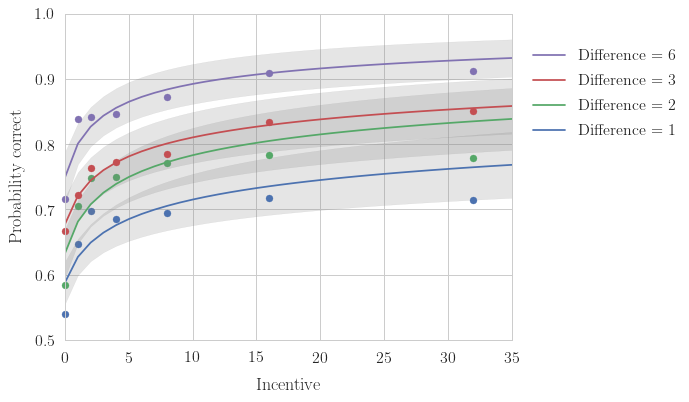

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, diff in enumerate(df['max'].unique()):
    
    ax.plot(np.arange(0,41), y_pred[i*41:i*41+41], label='Difference = {}'.format(diff),
            color=colors[i], alpha=1)
    ax.fill_between(np.arange(0,41), lb[i*41:i*41+41], ub[i*41:i*41+41], color='gray', alpha=0.2)#colors[i]
    
    df_aux = df[(df['max']==diff) & criteria][['Correct']].groupby([df['Incentives']]).mean()
    ax.scatter(df_aux.index.values, df_aux['Correct'].values,
               color=colors[i], clip_on=False)
    
    ax.tick_params(labelsize=16, pad=10)


handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = labels[::-1], handles[::-1]
ax.legend(handles, labels, loc=1, bbox_to_anchor=(1.4, 0.94), fontsize=16)    

ax.set_ylim([.5, 1])
ax.set_xlim([0, 35])
ax.set_ylabel(r'Probability correct', fontsize=18, labelpad=10)
ax.set_xlabel(r'Incentive', fontsize=18, labelpad=10)
#plt.legend(loc=1, bbox_to_anchor=(1.4, 0.9), fontsize=16)
plt.savefig('/home/daniel/Dropbox/JMP project/Figures/log_logit_weber.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

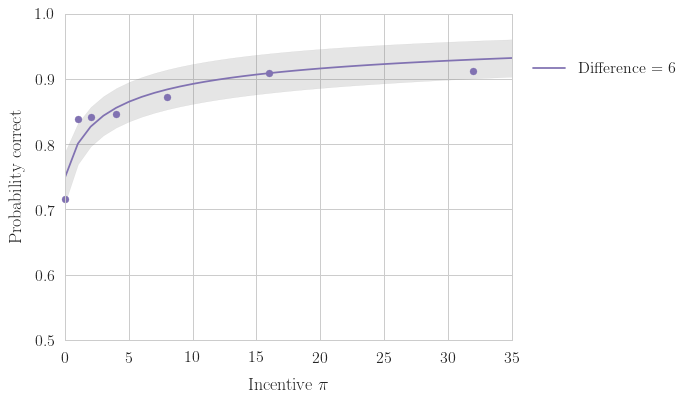

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))

#for i, diff in enumerate(df['max'].unique()):

i = 3
diff = 6

ax.plot(np.arange(0,41), y_pred[i*41:i*41+41], label='Difference = {}'.format(diff),
        color=colors[i], alpha=1)
ax.fill_between(np.arange(0,41), lb[i*41:i*41+41], ub[i*41:i*41+41], color='gray', alpha=0.2)#colors[i]

df_aux = df[(df['max']==diff) & criteria][['Correct']].groupby([df['Incentives']]).mean()
ax.scatter(df_aux.index.values, df_aux['Correct'].values,
           color=colors[i], clip_on=False)

ax.tick_params(labelsize=16, pad=10)


#handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
#labels, handles = labels[::-1], handles[::-1]
#ax.legend(handles, labels, loc=1, bbox_to_anchor=(1.4, 0.94), fontsize=16)    

ax.set_ylim([.5, 1])
ax.set_xlim([0, 35])
ax.set_ylabel(r'Probability correct', fontsize=18, labelpad=10)
ax.set_xlabel(r'Incentive $\pi$', fontsize=18, labelpad=10)
plt.legend(loc=1, bbox_to_anchor=(1.4, 0.9), fontsize=16)
plt.savefig('../Figures/Data/log_logit_weber_only6.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [71]:
B_12= np.array(([0,1,0,0,0,0,0,0],[0,0,0,0,0,1,0,0]))

B_13= np.array(([0,0,1,0,0,0,0,0],[0,0,0,0,0,0,1,0]))

B_16= np.array(([0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,1]))

B_23 = np.array(([0,1,-1,0,0,0,0,0],[0,0,0,0,0,1,-1,0]))
B_26 = np.array(([0,1,0,-1,0,0,0,0],[0,0,0,0,0,1,0,-1]))

B_36 = np.array(([0,0,1,-1,0,0,0,0],[0,0,0,0,0,0,1,-1]))

In [85]:
for test in [B_12, B_13, B_16, B_23, B_26, B_36]:
    print('{:.4f}'.format(float(model_pooled_log.f_test(test).pvalue)))

0.0372
0.0004
0.0000
0.2784
0.0000
0.0026


# Sensitvity Analysis to setting the threshold

In [86]:
model_log_thres = {}

for threshold in [1, 2, 5, 12]:
    criteria = (df['total time (min)']>=threshold)
    model_log_thres[threshold] = smf.logit(formula='Correct ~ C(max)*log_Incentives', 
                                           data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})


In [89]:
reg_names = ['1 minute', '2 minutes', '5 minutes', '12 minutes']
info_dict = {'Pseudo R-squared': lambda x: "{:.2f}".format(x.prsquared),
             'No. observations': lambda x: "{:d}".format(int(x.nobs))}

results = [model_log_thres[1], model_log_thres[2], model_log_thres[5], model_log_thres[12]]

reg_table = summary_col(results=results, 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)

reg_table.add_title('Sensitivity to values of the attentive time threshold')

#print(reg_table.as_latex())
print(reg_table)

      Sensitivity to values of the attentive time threshold
                           1 minute 2 minutes 5 minutes 12 minutes
------------------------------------------------------------------
Intercept                  0.259*** 0.299***  0.357***  0.493***  
                           (0.046)  (0.052)   (0.068)   (0.104)   
C(max)[T.2]                0.099    0.121     0.189*    0.194     
                           (0.072)  (0.082)   (0.106)   (0.148)   
C(max)[T.3]                0.164**  0.248***  0.387***  0.478***  
                           (0.075)  (0.085)   (0.118)   (0.174)   
C(max)[T.6]                0.549*** 0.623***  0.740***  0.841***  
                           (0.088)  (0.100)   (0.126)   (0.177)   
log_Incentives             0.134*** 0.158***  0.235***  0.469***  
                           (0.029)  (0.034)   (0.045)   (0.079)   
C(max)[T.2]:log_Incentives 0.030    0.043     0.073     0.001     
                           (0.043)  (0.049)   (0.069)   (0.114)   
C(

## Psychometric Curves

In [90]:
criteria = (df['total time (min)']>=5)

In [91]:
model_pooled_psycho = smf.logit(formula='Correct ~ C(Incentives)*max', 
                            data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})


In [92]:
exog_max = list(np.arange(1,7))

df_exog = pd.DataFrame({'max': exog_max*7, 'Incentives': [0]*6 + [1]*6 + [2]*6 + [4]*6 + [8]*6 + [16]*6 + [32]*6})
df_exog_patsy = dmatrix('C(Incentives)*max', data=df_exog, return_type="dataframe")

In [93]:
# getting critical value
dof = model_pooled_psycho.nobs - model_pooled_psycho.df_model
qt = stats.t.ppf(1-0.025, df=dof)

# get gradient of likelihood at prediction points
grad = ((model_pooled_psycho.predict(exog=df_exog)*
         (1-model_pooled_psycho.predict(exog=df_exog))).values*
        df_exog_patsy.values.T)

# standard error of regression
se = np.array([np.sqrt(model_pooled_psycho.cov_params(grad[:,x_pred]).iloc[0,0]) for x_pred in range(42)])

# logit regression
y_pred = model_pooled_psycho.predict(exog=df_exog).values

# confidence band
ub = y_pred + qt*se
lb = y_pred - qt*se

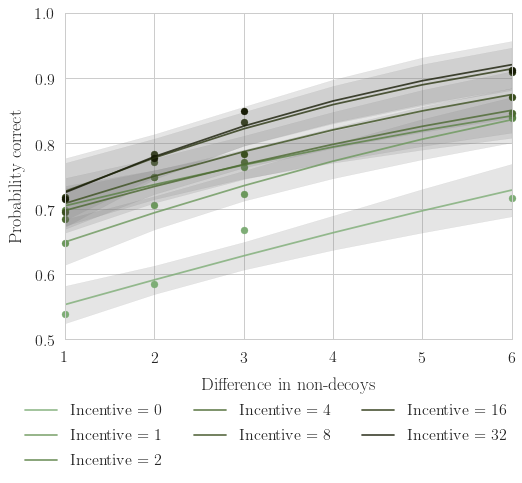

In [94]:
colors = sns.cubehelix_palette(7, start=1.5, rot=.2, dark=.1, light=.6)

fig, ax = plt.subplots(figsize=(8, 6))

for i, incent in enumerate(np.sort(df['Incentives'].unique())):
    
    ax.plot(np.arange(1,7), y_pred[i*6:i*6+6], color=colors[i], alpha=.8, 
            label='Incentive = {}'.format(incent))
    ax.fill_between(np.arange(1,7), lb[i*6:i*6+6], ub[i*6:i*6+6], color='gray', alpha=0.2)
    
    df_aux = df[(df['Incentives']==incent) & criteria][['Correct']].groupby([df['max']]).mean()
    ax.scatter(df_aux.index.values, df_aux['Correct'].values, color=colors[i], clip_on=False)
    

ax.tick_params(labelsize=16, pad=10)
    
ax.set_ylim([.5, 1])
ax.set_xlim([1, 6])
ax.set_ylabel(r'Probability correct', fontsize=18, labelpad=10)
ax.set_xlabel(r'Difference in non-decoys', fontsize=18, labelpad=10)
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), ncol = 3, fontsize=16)
plt.savefig('../Figures/Data/psycho.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

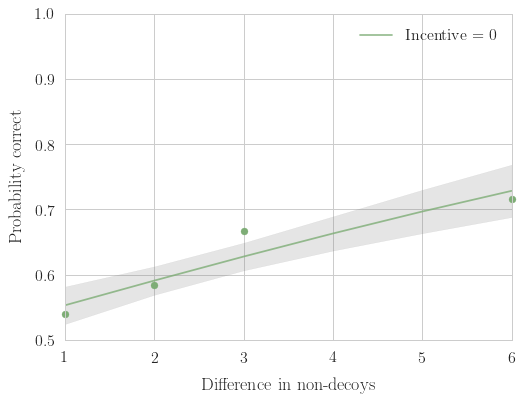

In [95]:
colors = sns.cubehelix_palette(7, start=1.5, rot=.2, dark=.1, light=.6)

fig, ax = plt.subplots(figsize=(8, 6))

i=0
incent=0
    
ax.plot(np.arange(1,7), y_pred[i*6:i*6+6], color=colors[i], alpha=.8, 
        label='Incentive = {}'.format(incent))
ax.fill_between(np.arange(1,7), lb[i*6:i*6+6], ub[i*6:i*6+6], color='gray', alpha=0.2)

df_aux = df[(df['Incentives']==incent) & criteria][['Correct']].groupby([df['max']]).mean()
ax.scatter(df_aux.index.values, df_aux['Correct'].values, color=colors[i], clip_on=False)
    

ax.tick_params(labelsize=16, pad=10)
    
ax.set_ylim([.5, 1])
ax.set_xlim([1, 6])
ax.set_ylabel(r'Probability correct', fontsize=18, labelpad=10)
ax.set_xlabel(r'Difference in non-decoys', fontsize=18, labelpad=10)
plt.legend(loc='upper right', fontsize=16)# bbox_to_anchor=(0.45, -0.15), ncol = 3
plt.savefig('../Figures/Data/psycho_incent0.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [96]:
model_psycho_thres = {}

for threshold in [1, 2, 5, 12]:
    criteria = (df['total time (min)']>=threshold)
    model_psycho_thres[threshold] = smf.logit(formula='Correct ~ C(Incentives)*max', 
                                              data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})



In [97]:
reg_names = ['1 minute', '2 minutes', '5 minutes', '12 minutes']
info_dict = {'Pseudo R-squared': lambda x: "{:.2f}".format(x.prsquared),
             'No. observations': lambda x: "{:d}".format(int(x.nobs))}

results = [model_psycho_thres[1], model_psycho_thres[2], 
           model_psycho_thres[5], model_psycho_thres[12]]

reg_table = summary_col(results=results, 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)

reg_table.add_title('Sensitivity to values of the attentive time threshold')

print(reg_table.as_latex())
#print(reg_table)

\begin{table}
\caption{Sensitivity to values of the attentive time threshold}
\begin{center}
\begin{tabular}{lcccc}
\hline
                        & 1 minute & 2 minutes & 5 minutes & 12 minutes  \\
\midrule
\midrule
Intercept               & 0.046    & 0.053     & 0.058     & 0.166       \\
                        & (0.058)  & (0.064)   & (0.079)   & (0.109)     \\
C(Incentives)[T.1]      & 0.121    & 0.200**   & 0.353***  & 0.507***    \\
                        & (0.077)  & (0.086)   & (0.107)   & (0.155)     \\
C(Incentives)[T.2]      & 0.362*** & 0.404***  & 0.649***  & 0.884***    \\
                        & (0.076)  & (0.085)   & (0.104)   & (0.154)     \\
C(Incentives)[T.4]      & 0.327*** & 0.385***  & 0.594***  & 0.973***    \\
                        & (0.083)  & (0.093)   & (0.118)   & (0.174)     \\
C(Incentives)[T.8]      & 0.336*** & 0.377***  & 0.616***  & 1.031***    \\
                        & (0.092)  & (0.104)   & (0.137)   & (0.208)     \\
C(Incentives)[T.16]    

# The psychometric Surface

In [8]:
criteria = (df['total time (min)']>=5)  

model = smf.logit(formula='Correct ~ max*np.log(Incentives+1)', 
                            data=df[criteria]).fit(cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})

Optimization terminated successfully.
         Current function value: 0.559300
         Iterations 6


In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Correct   No. Observations:                16080
Model:                          Logit   Df Residuals:                    16076
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Oct 2018   Pseudo R-squ.:                 0.03249
Time:                        18:54:58   Log-Likelihood:                -8993.5
converged:                       True   LL-Null:                       -9295.6
                                        LLR p-value:                1.331e-130
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2436      0.075      3.246      0.001       0.096       0.391
max                            0.1466      0.025      5.811      0.000       0.097       0.196
np.log(Incentives + 1)         0.2048      0.049      4.218      0.000       0.110       0.300
max:np.log(Incentives + 1)     0.0370      0.016      2.276      0.023       0.005       0.069
==============================================================================================
"""

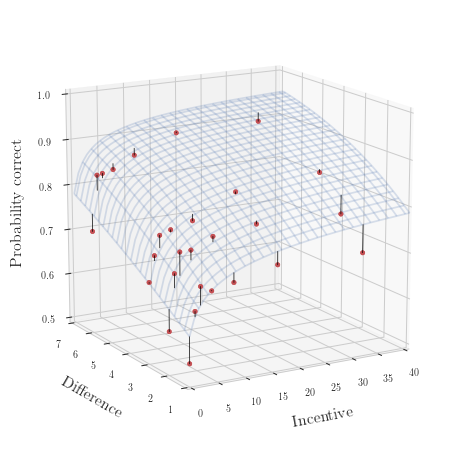

In [9]:
#exog_incent = list(np.log(np.arange(0,41)+1))
exog_incent = np.linspace(0, 41, 50)
exog_diff = np.linspace(1, 7, 50)

X, Y = np.meshgrid(exog_incent, exog_diff)
R = (model.params['Intercept'] + model.params['np.log(Incentives + 1)']*np.log(X+1) + model.params['max']*Y + 
     model.params['max:np.log(Incentives + 1)']*np.log(X+1)*Y)
Z = np.exp(R)/(1 + np.exp(R))


x_scat = df[criteria]['Correct'].groupby([df['Incentives'], df['max']]).mean().index.get_level_values(0).values
y_scat = df[criteria]['Correct'].groupby([df['Incentives'], df['max']]).mean().index.get_level_values(1).values
z_scat = df[criteria]['Correct'].groupby([df['Incentives'], df['max']]).mean().values
r_scat_surface = (model.params['Intercept'] + model.params['np.log(Incentives + 1)']*np.log(x_scat+1) + model.params['max']*y_scat + 
     model.params['max:np.log(Incentives + 1)']*np.log(x_scat+1)*y_scat)
z_scat_surface = np.exp(r_scat_surface)/(1+np.exp(r_scat_surface))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, alpha=.2)
ax.scatter(x_scat, y_scat, z_scat, color=colors[2], alpha=.9)
for i in range(len(x_scat)):
    ax.plot([x_scat[i], x_scat[i]], [y_scat[i], y_scat[i]], [z_scat[i], z_scat_surface[i]], color='k', lw=.7)
ax.scatter(x_scat, y_scat, z_scat, color=colors[2], alpha=.9)
ax.set_zlim3d(0.5, 1)
ax.set_ylim3d(1, 7) 
ax.set_xlim3d(0, 40) 
ax.set_xlabel('Incentive', fontsize=16, labelpad=15)
ax.set_ylabel('Difference', fontsize=16, labelpad=15)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Probability correct', fontsize=16, labelpad=15, rotation=90)
ax.view_init(15, 240)
plt.savefig('../Figures/Data/3d_weber.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

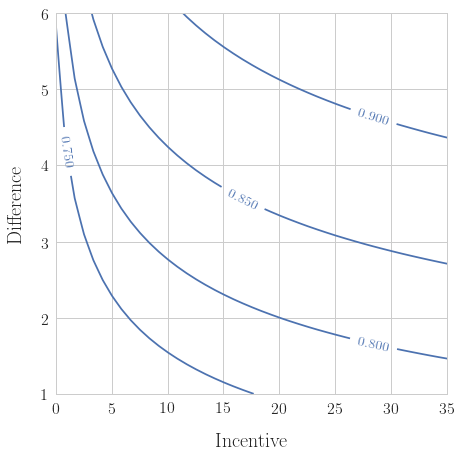

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))

#ax.text(mean_true+.002, sd_true**2+.002, r'$\theta_{\text{KL}}$', color='k', fontsize=18)
CS = ax.contour(X, Y, Z, levels=[.75, .8, .85, .9], alpha=1, colors=colors[0])

ax.set_xlabel(r'Incentive', fontsize=20, labelpad=15)
ax.set_ylabel(r'Difference', fontsize=20, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.clabel(CS, inline=1, fontsize=14)

ax.set_ylim([1, 6])
ax.set_xlim([0, 35])

#ax.legend(loc=1, fontsize = 16)#bbox_to_anchor=(.5, -0.25), ncol=3,
plt.savefig('../Figures/Data/isoperformance.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

# Welfare and Cost Measures

Measure the welfare and costs using the log transform. Normalize the utility of the final prize to $u(\$10) = 1$. 

In order to transform the probability of getting an answer correct to EU terms we have to take into account that 50% chance of being correct translates to 100 point which yields 0 EU. This is important for computing gross welfare.
The formula the expected utility under final score $X$ is
$$ \max\left\{0, \frac{X-100}{100}\right\} u(\$10)$$

Assume that one is above the 100 threshold so that we don't have to deal with the kink.





In [43]:
from scipy.integrate import quad

In [44]:
def gross_welfare(i, a, b):
    return (np.exp(a + b*np.log(i+1))/(1 + np.exp(a + b*np.log(i+1)))) * (i/100)


def integrand(i, a, b):
    return np.exp(a + b*np.log(i+1))/(1 + np.exp(a + b*np.log(i+1)))
   

In [45]:
criteria = (df['total time (min)'] >=5)

model_pooled_log = smf.logit(formula='Correct ~ C(max)*log_Incentives', 
                            data=df[criteria]).fit(disp=0)

In [46]:
I = np.linspace(0, 40, 100000)

Gross_Welfare = np.empty((4, 100000))


for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    Gross_Welfare[i, :] = gross_welfare(I, a, b)


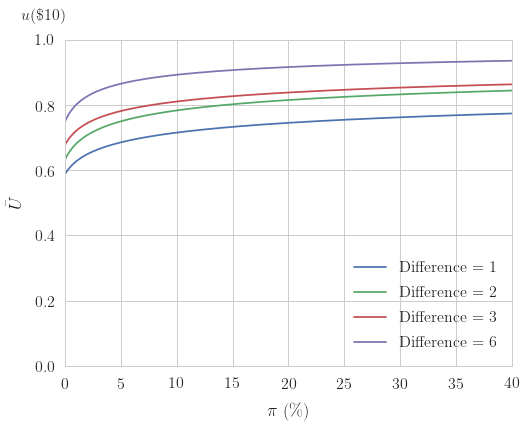

In [100]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(8, 6))

for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    
    ax.plot(I, integrand(I, a, b), label='Difference = {}'.format(diff), color=colors[i], alpha=1)

    
ax.tick_params(labelsize=16, pad=10)
ax.text(-4, 1.06, r'$u(\$10)$', fontsize=16)
    
ax.set_ylim([0, 1])
ax.set_xlim([0, 40])
ax.set_ylabel(r'$\bar{U}$', fontsize=18, labelpad=10) # -- in fraction of $u(\$10)$
ax.set_xlabel(r'$\pi$ (\%)', fontsize=18, labelpad=10)
plt.legend(loc=4, fontsize=16)
plt.savefig('../Figures/Data/estimated_weber.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

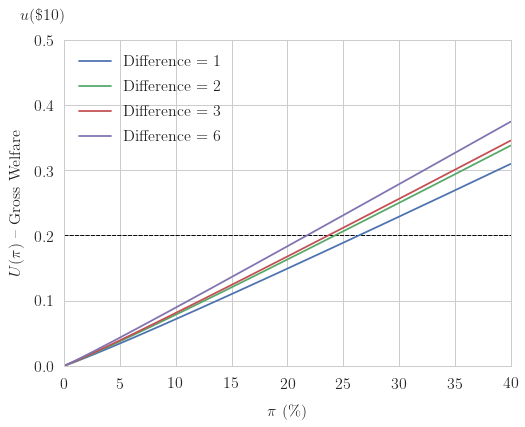

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, diff in enumerate(df['max'].unique()):
    
    ax.plot(I, Gross_Welfare[i,:], label='Difference = {}'.format(diff), color=colors[i])
    ax.hlines(.2, 0, 40, linestyle='--', lw=1, color='k', alpha=.5)

ax.tick_params(labelsize=16, pad=10)
ax.text(-4, .53, r'$u(\$10)$', fontsize=16)
ax.set_ylim([0, .5])
ax.set_xlim([0, 40])
ax.set_ylabel(r'$U(\pi)$ -- Gross Welfare', fontsize=16, labelpad=10)
ax.set_xlabel(r'$\pi$ (\%)', fontsize=16, labelpad=10)
plt.legend(loc=2, fontsize=16)
plt.savefig('../Figures/Data/gross_welfare.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

Take gross welfare level of 10% of u(\$10) and check what is the incentive that is needed to achieve it for each difficulty level. 

In [47]:
Idx = []
for i, diff in enumerate(df['max'].unique()):
    idx = np.argmin(np.abs(Gross_Welfare[i,:]-.2))
    Idx.append(idx)
    print('Under difference of {} to achieve gross welfare level of .1 we need incentive {:.4f}'.format(int(diff), I[idx]))

Under difference of 1 to achieve gross welfare level of .1 we need incentive 26.4331
Under difference of 2 to achieve gross welfare level of .1 we need incentive 24.2914
Under difference of 3 to achieve gross welfare level of .1 we need incentive 23.6886
Under difference of 6 to achieve gross welfare level of .1 we need incentive 21.7734


The precision needed to achieve gross welfare of .10 is:

In [48]:
for i, diff in enumerate(df['max'].unique()):
    precision = Gross_Welfare[i, Idx[i]]/(I[Idx[i]]/100)
    print('Precision corresponding to gross welfare of .10 under difference {} is {:.2f}%'.format(diff, precision*100))


Precision corresponding to gross welfare of .10 under difference 1 is 75.66%
Precision corresponding to gross welfare of .10 under difference 2 is 82.33%
Precision corresponding to gross welfare of .10 under difference 3 is 84.43%
Precision corresponding to gross welfare of .10 under difference 6 is 91.86%


In [49]:
Net_Welfare = []

for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    Net_Welfare.append(quad(integrand, 0, I[Idx[i]], args=(a,b))[0]/100)


In [50]:
print(["{0:0.4f}".format(i) for i in Net_Welfare])

['0.1891', '0.1892', '0.1908', '0.1923']


Cost of achieving welfare of 20% of u(\$10):

In [51]:
print(["{0:0.4f}".format(.2-i) for i in Net_Welfare])

['0.0109', '0.0108', '0.0092', '0.0077']


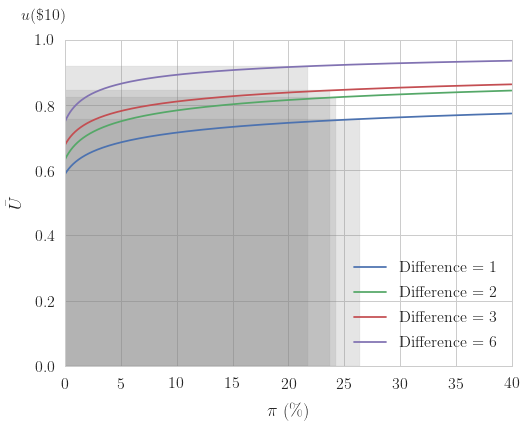

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    
    ax.plot(I, integrand(I, a, b), label='Difference = {}'.format(diff), color=colors[i], alpha=1)
    ax.fill_between([0, I[Idx[i]]], 0, integrand(I[Idx[i]], a, b), color='gray', alpha=.2)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = labels[::-1], handles[::-1]
ax.legend(handles, labels, loc=1, bbox_to_anchor=(1.4, 0.94), fontsize=16)       

ax.tick_params(labelsize=16, pad=10)
ax.text(-4, 1.06, r'$u(\$10)$', fontsize=16)
    
ax.set_ylim([0, 1])
ax.set_xlim([0, 40])
ax.set_ylabel(r'$\bar{U}$', fontsize=18, labelpad=10)
ax.set_xlabel(r'$\pi$ (\%)', fontsize=18, labelpad=10)
#plt.legend(loc=4, fontsize=16)
plt.savefig('../Figures/Data/welfare_weber.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [72]:
I[Idx[i]]

21.773417734177343

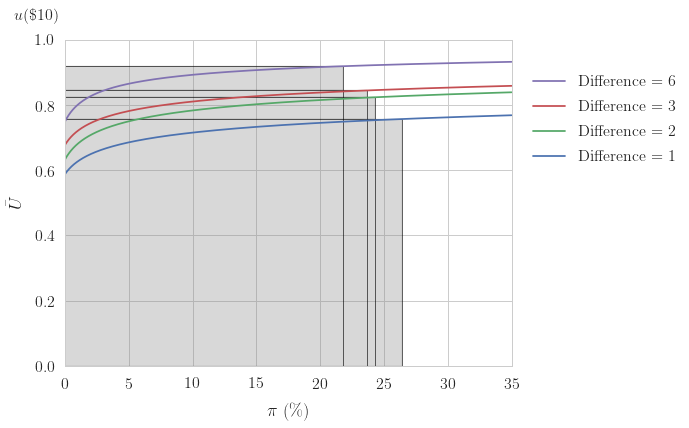

In [76]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(8, 6))

a = np.empty(4)
b = np.empty(4)
for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a[i] = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b[i] = model_pooled_log.params.values @ coeff_select
    
    ax.hlines(integrand(I[Idx[i]], a[i], b[i]), 0, I[Idx[i]], color='k', lw=.6)
    ax.vlines(I[Idx[i]], 0, integrand(I[Idx[i]], a[i], b[i]), color='k', lw=.6)
    ax.plot(I, integrand(I, a[i], b[i]), label='Difference = {}'.format(diff), color=colors[i], alpha=1)
    
    
ax.fill_between([0, I[Idx[0]]], 0, integrand(I[Idx[0]], a[0], b[0]), facecolor='gray', edgecolor='black', alpha=.3)
ax.fill_between([0, I[Idx[1]]], integrand(I[Idx[0]], a[0], b[0]), integrand(I[Idx[1]], a[1], b[1]),
                facecolor='gray', edgecolor='black', alpha=.3)
ax.fill_between([0, I[Idx[2]]], integrand(I[Idx[1]], a[1], b[1]), integrand(I[Idx[2]], a[2], b[2]),
                facecolor='gray', edgecolor='black', alpha=.3)
ax.fill_between([0, I[Idx[3]]], integrand(I[Idx[2]], a[2], b[2]), integrand(I[Idx[3]], a[3], b[3]),
                facecolor='gray', edgecolor='black', alpha=.3)


handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = labels[::-1], handles[::-1]
ax.legend(handles, labels, loc=1, bbox_to_anchor=(1.4, 0.94), fontsize=16)       

ax.tick_params(labelsize=16, pad=10)
ax.text(-4, 1.06, r'$u(\$10)$', fontsize=16)
    
ax.set_ylim([0, 1])
ax.set_xlim([0, 35])
ax.set_ylabel(r'$\bar{U}$', fontsize=18, labelpad=10)
ax.set_xlabel(r'$\pi$ (\%)', fontsize=18, labelpad=10)
#plt.legend(loc=4, fontsize=16)
plt.savefig('../Figures/Data/welfare_weber.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

## Relationship of Estimated Cost and Time


For each difficulty level and at each incentive level we compute achieved probability of being correct. 

We compute the cost in two ways:  as the cost of the EU corresponding to the probability of being correct; as the cost corresponding to the incentive level based on the estimated Weber curve. 

We compute mean and median times for each of these cells and compare then with the cost.

In [103]:
df_CT = df[criteria][['Correct', 'time_round']].groupby([df['max'], df['Incentives']]).mean()
df_CT.rename(columns={'time_round': 'mean time'}, inplace=True)

df_CT_median = df[criteria][['time_round']].groupby([df['max'], df['Incentives']]).median()
df_CT_median.rename(columns={'time_round': 'median time'}, inplace=True)

df_CT = df_CT.join(df_CT_median)

In [104]:
def logit_curve(i, a, b):
    return np.exp(a + b*np.log(i+1))/(1 + np.exp(a + b*np.log(i+1)))


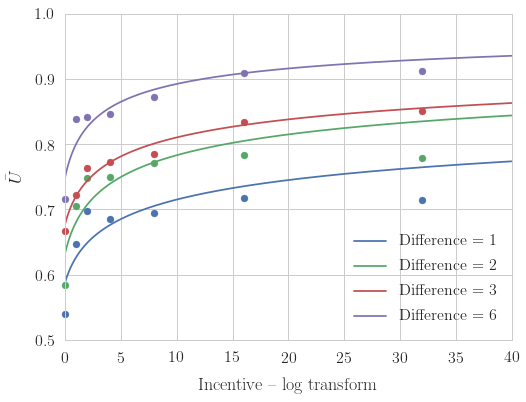

In [105]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    
    ax.plot(I, logit_curve(I, a, b), label='Difference = {}'.format(diff), color=colors[i], alpha=1)
    
    df_aux = df[(df['max']==diff) & criteria][['Correct']].groupby([df['Incentives']]).mean()
    ax.scatter(df_aux.index.values, df_aux['Correct'].values, color=colors[i], clip_on=False)
    
    ax.tick_params(labelsize=16, pad=10)

    
ax.set_ylim([0.5, 1])
ax.set_xlim([0, 40])
ax.set_ylabel(r'$\bar{U}$', fontsize=18, labelpad=10)
ax.set_xlabel(r'Incentive -- log transform', fontsize=18, labelpad=10)
plt.legend(loc=4, fontsize=16)
#plt.savefig('../Figures/Data/log_logit_weber.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [106]:
I = np.linspace(0, 40, 100000)

prob_correct = np.empty((4, 100000))


for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    prob_correct[i, :] = logit_curve(I, a, b)


In [107]:
I_probs = []
gross_welfare_01 = []
net_welfare_01 = []
gross_welfare_02 = []
net_welfare_02 = []


for i, diff in enumerate(df['max'].unique()):
    intercept_select = np.array([1, 0, 0, 0, 0, 0, 0, 0])
    intercept_select.put(i, 1)
    a = model_pooled_log.params.values @ intercept_select
    
    coeff_select = np.array([0, 0, 0, 0, 1, 0, 0, 0])
    coeff_select.put(i+4, 1)
    b = model_pooled_log.params.values @ coeff_select
    
    for incent in np.sort(df['Incentives'].unique()):
        # Cost based on incentive
        gross_welfare_01.append(gross_welfare(incent, a, b))
        net_welfare_01.append(quad(integrand, 0, incent, args=(a,b))[0]/100)
        
        # Cost based on achieved prob. of being correct
        idx = np.argmin(np.abs(prob_correct[i,:] - df_CT.loc[diff, incent]['Correct']))
        I_probs.append(I[idx])
        gross_welfare_02.append(Gross_Welfare[i,idx])
        net_welfare_02.append(quad(integrand, 0, I[idx], args=(a,b))[0]/100)


In [108]:
df_CT['cost (prob. correct)'] = np.array(gross_welfare_02) - np.array(net_welfare_02)
df_CT['cost (incentive)'] = np.array(gross_welfare_01) - np.array(net_welfare_01)

In [130]:
df_CT.corr()

,Correct,mean time,median time,cost (prob. correct),cost (incentive)
Correct,1.000000,0.436253,0.560469,0.576955,0.412485
mean time,0.436253,1.000000,0.933160,0.734316,0.796926
median time,0.560469,0.933160,1.000000,0.821413,0.879912
cost (prob. correct),0.576955,0.734316,0.821413,1.000000,0.800795
cost (incentive),0.412485,0.796926,0.879912,0.800795,1.000000


In [111]:
print(df_CT.drop(columns=['cost (prob. correct)']).corr().round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Correct &  mean time &  median time &  cost (incentive) \\
\midrule
Correct          &    1.000 &      0.436 &        0.560 &             0.412 \\
mean time        &    0.436 &      1.000 &        0.933 &             0.797 \\
median time      &    0.560 &      0.933 &        1.000 &             0.880 \\
cost (incentive) &    0.412 &      0.797 &        0.880 &             1.000 \\
\bottomrule
\end{tabular}



In [131]:
print(df_CT.corr().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   Correct &  mean time &  median time &  cost (prob. correct) &  cost (incentive) \\
\midrule
Correct              &  1.000000 &   0.436253 &     0.560469 &              0.576955 &          0.412485 \\
mean time            &  0.436253 &   1.000000 &     0.933160 &              0.734316 &          0.796926 \\
median time          &  0.560469 &   0.933160 &     1.000000 &              0.821413 &          0.879912 \\
cost (prob. correct) &  0.576955 &   0.734316 &     0.821413 &              1.000000 &          0.800795 \\
cost (incentive)     &  0.412485 &   0.796926 &     0.879912 &              0.800795 &          1.000000 \\
\bottomrule
\end{tabular}



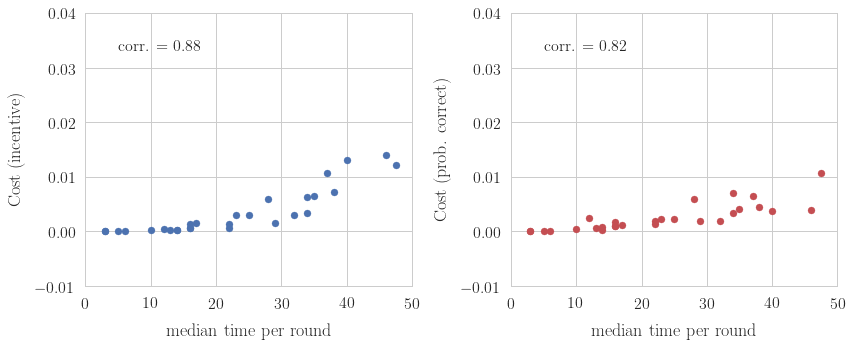

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df_CT[['median time']], df_CT[['cost (incentive)']], color=colors[0])
axes[0].text(5, .033, 'corr. = 0.88', fontsize=16)
axes[1].scatter(df_CT[['median time']], df_CT['cost (prob. correct)'], color=colors[2])
axes[1].text(5, .033, 'corr. = 0.82', fontsize=16)



axes[0].set_ylim([-.01, .04])
axes[1].set_ylim([-.01, .04])
axes[0].set_xlim([0, 50])
axes[1].set_xlim([0, 50])

axes[0].set_ylabel(r'Cost (incentive)', fontsize=18, labelpad=10)
axes[1].set_ylabel(r'Cost (prob. correct)', fontsize=18, labelpad=10)
axes[0].tick_params(labelsize=16, pad=10)

axes[0].set_xlabel(r'median time per round', fontsize=18, labelpad=10)
axes[1].set_xlabel(r'median time per round', fontsize=18, labelpad=10)
axes[1].tick_params(labelsize=16, pad=10)

#axes[0].legend(fontsize=16)
#axes[1].legend(fontsize=16)
plt.tight_layout()
plt.savefig('../Figures/Data/time_cost_corr.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

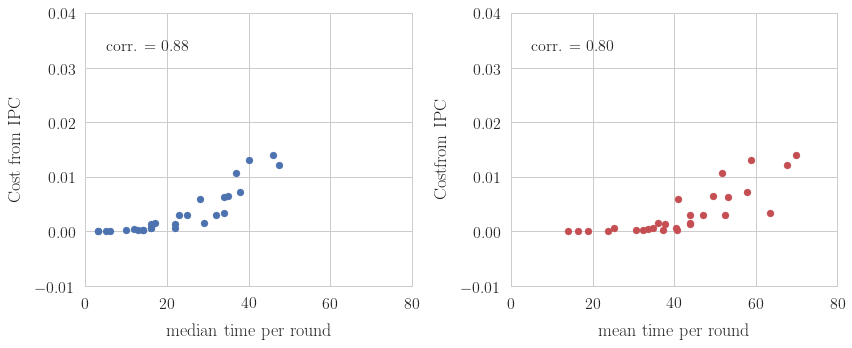

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df_CT[['median time']], df_CT[['cost (incentive)']], color=colors[0])
axes[0].text(5, .033, 'corr. = 0.88', fontsize=16)
axes[1].scatter(df_CT[['mean time']], df_CT['cost (incentive)'], color=colors[2])
axes[1].text(5, .033, 'corr. = 0.80', fontsize=16)



axes[0].set_ylim([-.01, .04])
axes[1].set_ylim([-.01, .04])
axes[0].set_xlim([0, 80])
axes[1].set_xlim([0, 80])

axes[0].set_ylabel(r'Cost from IPC', fontsize=18, labelpad=10)
axes[1].set_ylabel(r'Costfrom IPC', fontsize=18, labelpad=10)
axes[0].tick_params(labelsize=16, pad=10)

axes[0].set_xlabel(r'median time per round', fontsize=18, labelpad=10)
axes[1].set_xlabel(r'mean time per round', fontsize=18, labelpad=10)
axes[1].tick_params(labelsize=16, pad=10)

#axes[0].legend(fontsize=16)
#axes[1].legend(fontsize=16)
plt.tight_layout()
plt.savefig('../Figures/Data/time_cost_corr.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

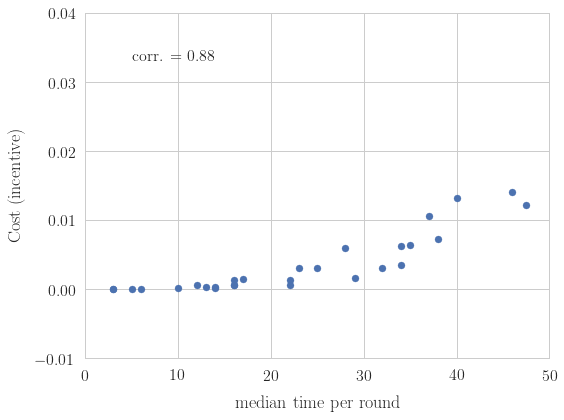

In [196]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df_CT[['median time']], df_CT[['cost (incentive)']], color=colors[0])
ax.text(5, .033, 'corr. = 0.88', fontsize=16)

ax.set_ylim([-.01, .04])
ax.set_xlim([0, 50])

ax.set_ylabel(r'Cost (incentive)', fontsize=18, labelpad=10)
ax.tick_params(labelsize=16, pad=10)

ax.set_xlabel(r'median time per round', fontsize=18, labelpad=10)

#axes[0].legend(fontsize=16)
#axes[1].legend(fontsize=16)
plt.tight_layout()
plt.savefig('../Figures/Data/time_cost_corr_single.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

# Allowing for State Dependence


In [98]:
# Empirical frequency of the states

df['state'].value_counts(normalize=True)

nonagon     0.501658
heptagon    0.498342
Name: state, dtype: float64

In [99]:
df['state'].groupby([df['max']]).value_counts(normalize=True)

max  state   
1    nonagon     0.504148
     heptagon    0.495852
2    nonagon     0.504103
     heptagon    0.495897
3    nonagon     0.501202
     heptagon    0.498798
6    heptagon    0.503324
     nonagon     0.496676
Name: state, dtype: float64

## Pooling across all difficulty levels.

In [101]:
criteria = (df['total time (min)']>=5)

test_sdsc_sym_pooled = smf.logit(formula='Correct ~ C(state)*np.log(Incentives+1)', data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})


In [106]:
reg_names = ['State dependence']
info_dict = {'Pseudo R-squared': lambda x: "{:.2f}".format(x.prsquared),
             'No. observations': lambda x: "{:d}".format(int(x.nobs))}


reg_table = summary_col([test_sdsc_sym_pooled], 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)

reg_table.add_title('State Dependent Asymmetry')

print(reg_table.as_latex())#

\begin{table}
\caption{State Dependent Asymmetry}
\begin{center}
\begin{tabular}{lc}
\hline
                                           & State dependence  \\
\midrule
\midrule
Intercept                                  & 0.602***          \\
                                           & (0.056)           \\
C(state)[T.nonagon]                        & 0.132*            \\
                                           & (0.072)           \\
np.log(Incentives + 1)                     & 0.299***          \\
                                           & (0.033)           \\
C(state)[T.nonagon]:np.log(Incentives + 1) & -0.008            \\
                                           & (0.045)           \\
Pseudo R-squared                           & 0.01              \\
No. observations                           & 16080             \\
\hline
\end{tabular}
\end{center}
\end{table}


In [107]:
hypotheses = '(C(state)[T.nonagon]=0), (C(state)[T.nonagon]:np.log(Incentives + 1)=0)'

In [108]:
p_val = float(test_sdsc_sym_pooled.f_test(hypotheses).pvalue)
print('For pooled difference p_value of the hypothesis\nthat nonagon and heptagon states are the same is: {0:.4f}'.format(p_val))

For pooled difference p_value of the hypothesis
that nonagon and heptagon states are the same is: 0.1011


## Splitting difficulty levels in separate regressions

In [109]:
test_sdsc_sym = []

for diff in np.sort(df['max'].unique()):
    criteria = (df['total time (min)']>=5) & (df['max']==diff)
    test_sdsc_sym.append(smf.logit(formula='Correct ~ C(state)*log_Incentives', data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})
)

In [110]:
reg_names = ['Diff. 1', 'Diff. 2', 'Diff. 3', 'Diff. 6']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}


reg_table = summary_col([test_sdsc_sym[0], test_sdsc_sym[1], test_sdsc_sym[2], test_sdsc_sym[3]], 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)

reg_table.add_title('State Dependent Asymmetry')

print(reg_table)#.as_latex()

                      State Dependent Asymmetry
                                   Diff. 1  Diff. 2  Diff. 3  Diff. 6 
----------------------------------------------------------------------
Intercept                          0.420*** 0.513*** 0.612*** 0.855***
                                   (0.096)  (0.103)  (0.114)  (0.133) 
C(state)[T.nonagon]                -0.123   0.061    0.268**  0.518***
                                   (0.125)  (0.157)  (0.120)  (0.186) 
log_Incentives                     0.220*** 0.285*** 0.280*** 0.498***
                                   (0.060)  (0.063)  (0.055)  (0.088) 
C(state)[T.nonagon]:log_Incentives 0.030    0.050    0.034    -0.156  
                                   (0.075)  (0.095)  (0.083)  (0.122) 
Pseudo R-squared                   0.01     0.01     0.02     0.03    
No. observations                   4480     3880     3600     4120    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


F-tests for the difference across states.

In [111]:
hypotheses = '(C(state)[T.nonagon]=0), (C(state)[T.nonagon]:log_Incentives=0)'

In [112]:
print('The p-value for testing the state dependent probabilities being equal.')
for i, diff in enumerate(np.sort(df['max'].unique())):
    p_val = float(test_sdsc_sym[i].f_test(hypotheses).pvalue)
    print('='*80)
    print('Under differences in non-decoys being {:1d}'.format(diff), 'p_value is: {0:.4f}'.format(p_val))

The p-value for testing the state dependent probabilities being equal.
Under differences in non-decoys being 1 p_value is: 0.6101
Under differences in non-decoys being 2 p_value is: 0.5490
Under differences in non-decoys being 3 p_value is: 0.0146
Under differences in non-decoys being 6 p_value is: 0.0220


In [113]:
criteria = (df['total time (min)']>=5)

In [167]:
df[criteria][['Correct']].groupby([df['max'], df['state'], df['Incentives']]).mean().unstack(level=(0, 1))

Correct                                                    \
max                1                   2                   3             
state       heptagon   nonagon  heptagon   nonagon  heptagon   nonagon   
Incentives                                                               
0           0.571101  0.508696  0.567416  0.597619  0.630372  0.700809   
1           0.634744  0.659955  0.703125  0.706633  0.698667  0.747826   
2           0.702576  0.692964  0.734584  0.761787  0.742120  0.784367   
4           0.701183  0.667665  0.730375  0.768166  0.722433  0.819495   
8           0.724528  0.667797  0.761702  0.780000  0.782407  0.786325   
16          0.696774  0.734807  0.773333  0.794326  0.794118  0.873134   
32          0.723214  0.705357  0.757282  0.802198  0.816092  0.881720   

                                
max                6            
state       heptagon   nonagon  
Incentives                      
0           0.669154  0.760664  
1           0.798595  0.881612  
2           0.830317  0.853403  
4           0.805921  0.885350  
8           0.875502  0.868421  
16          0.901235  0.918367  
32          0.920000  0.905660

## Joint regression with difficulty and state

In [168]:
criteria = (df['total time (min)'] >=5)

model_sdsc = smf.logit(formula='Correct ~ C(state)*C(max)*log_Incentives', 
                                  data=df[criteria]).fit(disp=0)

In [169]:
reg_names = ['Pooled differences']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}


reg_table = summary_col([model_sdsc], 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)

reg_table.add_title('State Dependent Asymmetry')

print(reg_table.as_latex())

\begin{table}
\caption{State Dependent Asymmetry}
\begin{center}
\begin{tabular}{lc}
\hline
                                                & Pooled differences  \\
\midrule
\midrule
Intercept                                       & 0.420***            \\
                                                & (0.073)             \\
C(state)[T.nonagon]                             & -0.123              \\
                                                & (0.102)             \\
C(max)[T.2]                                     & 0.093               \\
                                                & (0.109)             \\
C(max)[T.3]                                     & 0.192*              \\
                                                & (0.112)             \\
C(max)[T.6]                                     & 0.435***            \\
                                                & (0.113)             \\
C(state)[T.nonagon]:C(max)[T.2]                 & 0.183               \\
              

In [170]:
# difference in states for difficulty 1
hypotheses = '(C(state)[T.nonagon]=0), (C(state)[T.nonagon]:log_Incentives=0)'

print(model_sdsc.f_test(hypotheses).pvalue)

0.3489509143245798


In [171]:
# difference in states for difficulty 2
hypotheses = '(C(state)[T.nonagon]:C(max)[T.2] = C(max)[T.2]), (C(max)[T.2]:log_Incentives = C(state)[T.nonagon]:C(max)[T.2]:log_Incentives)'

print(model_sdsc.f_test(hypotheses).pvalue)

0.9336338583052777


In [172]:
# difference in states for difficulty 3
hypotheses = '(C(state)[T.nonagon]:C(max)[T.3] = C(max)[T.3]), (C(max)[T.3]:log_Incentives = C(state)[T.nonagon]:C(max)[T.3]:log_Incentives)'

print(model_sdsc.f_test(hypotheses).pvalue)

0.65972272132657


In [173]:
# difference in states for difficulty 6
hypotheses = '(C(state)[T.nonagon]:C(max)[T.6] = C(max)[T.6]), (C(max)[T.6]:log_Incentives = C(state)[T.nonagon]:C(max)[T.6]:log_Incentives)'

print(model_sdsc.f_test(hypotheses).pvalue)

0.008524596546725736


# Allowing for state dependence
# with sensitivity analysis

In [114]:
model_sdsc = {}

for th in [1, 2, 5, 10]:
    criteria = (df['total time (min)']>=th)    
    model_sdsc[th] = smf.logit(formula='Correct ~ C(state)*C(max)*np.log(Incentives + 1)', 
                           data=df[criteria]).fit(disp=0, cov_type='cluster', cov_kwds={'groups': df[criteria]['usercode']})


In [115]:
reg_names = ['1 minute', '2 minutes', '5 minutes', '12 minutes']
info_dict = {'Pseudo R-squared': lambda x: "{:.2f}".format(x.prsquared),
             'No. observations': lambda x: "{:d}".format(int(x.nobs))}

results = [model_sdsc[1], model_sdsc[2], model_sdsc[5], model_sdsc[10]]

reg_table = summary_col(results=results, 
                        float_format='%0.3f',
                        stars=True,
                        model_names=reg_names,
                        info_dict=info_dict)

reg_table.add_title('Allowing for state dependence')

print(reg_table.as_latex())
#print(reg_table)

\begin{table}
\caption{Allowing for state dependence}
\begin{center}
\begin{tabular}{lcccc}
\hline
                                                       & 1 minute & 2 minutes & 5 minutes & 12 minutes  \\
\midrule
\midrule
Intercept                                              & 0.274*** & 0.295***  & 0.420***  & 0.667***    \\
                                                       & (0.072)  & (0.079)   & (0.096)   & (0.131)     \\
C(state)[T.nonagon]                                    & -0.030   & 0.008     & -0.123    & -0.363**    \\
                                                       & (0.104)  & (0.108)   & (0.124)   & (0.161)     \\
C(max)[T.2]                                            & 0.015    & 0.091     & 0.093     & 0.016       \\
                                                       & (0.098)  & (0.109)   & (0.141)   & (0.179)     \\
C(max)[T.3]                                            & 0.052    & 0.186     & 0.192     & 0.187       \\
                           